# Investigating periods of increasing interest rates for the S&P 1500
### by Luca Reichelt, 999786

## 1. Outline

This project aims to investigate periods of increasing interest rates by the federal reserve based on the constituents of the S&P 1500. As an end result we attempt to implement our findings into a portfolio strategy.

The first month of observation is defined as the month of the first hike. The last date of observation is defined as the last month before a decreasing or stagnant interest rate (no change). Company data is based on the latest data available which have been published before the first day.
We do not adjust for changes in the SP1500, but will include all the data available for its constituents as of the first month of the respective period.

All of the data that isn't retrieved while executing the code has been exported from Bloomberg Terminal or investing.com and is available within the folder "data_raw" in xlsx format. The data which is retrieved during the code execution is retrieved from Yahoo Finance or the FRED API, which is a API provided by the Federal Reserve of St.Lewis (https://fred.stlouisfed.org/docs/api/fred/).

You should be able to run this notebook after creating a local environment using anconda/miniconda and executing following command while referring to the provided yaml file:

`conda env create --file=env.yml`

## 2. Data

In [14]:
# importing the main packages
from datetime import datetime, timedelta
import os
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import dataframe_image as dfi
import pickle as pkl


### 2.1 Data Retrieval

In [15]:
# getting the last periods of increasing interest rates (Federal Funds Effective MONTHLY Rate) from 1995 onwards
fed_rates = web.DataReader('FEDFUNDS', "fred", 1995)
fed_rates.set_index(fed_rates.index.astype('datetime64[ns]'), inplace=True)

periods = pd.DataFrame(columns=["Name", "Start", "Last"])
periods.loc[periods.shape[0]] = [None, None, None]

period = 0
j = 0

# we search for periods that are at least 9 months (eight fed rate decisions)
for i in range(0, len(fed_rates)-1):
    if (fed_rates.iloc[i+1]['FEDFUNDS'] <= fed_rates.iloc[i]['FEDFUNDS']) and (i-j >= 9):
        periods.loc[period]["Last"] = datetime.strftime(
            fed_rates.index[i], '%Y-%m-%d')
        period += 1
        if (datetime.date(fed_rates.index[-1])-datetime.date(fed_rates.index[i])).days >= 365:
            periods.loc[periods.shape[0]] = [None, None, None]
        j = i
    elif (fed_rates.iloc[i+1]['FEDFUNDS'] <= fed_rates.iloc[i]['FEDFUNDS']) and (i-j < 9):
        periods.loc[period]["Name"] = "Period " + str(period+1)
        periods.loc[period]["Start"] = datetime.strftime(
            fed_rates.index[i], '%Y-%m-%d')
        j = i

# adding the last date for the current one
periods.loc[period]["Last"] = datetime.strftime(
    fed_rates.index[-1], '%Y-%m-%d')
periods["Duration"] = ((pd.to_datetime(periods["Last"]) -
                       pd.to_datetime(periods["Start"]))/np.timedelta64(1, 'M')).astype(int)
dfi.export(periods, "periods.png")
periods


Name       Start        Last  Duration
0  Period 1  2004-04-01  2006-08-01        27
1  Period 2  2016-09-01  2017-08-01        10
2  Period 3  2017-09-01  2018-07-01         9
3  Period 4  2022-01-01  2023-03-01        13

In [16]:
def web_import(rate, start, end):
    df = web.DataReader(rate, "fred", start, end)
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    return df


In [17]:
def yf_import(ticker, start, end):
    data = yf.download(ticker, start, end)
    monthly = data.groupby(pd.PeriodIndex(data.index, freq="M"))[
        "Close"].mean()

    if data.size > 0:
        if not data.empty == True and len(monthly.values) == round((data.index[-1] - data.index[0])/np.timedelta64(1, 'M')) and len(monthly.values) >= 9:
            df = pd.DataFrame(index=pd.date_range(start, end, freq='MS'), data=np.append(
                monthly.values, data.iloc[-1]["Close"]))
            df.rename(columns={df.columns[0]: ticker}, inplace=True)
            df.drop(columns=df.columns.difference([ticker]), inplace=True)
            df.index = pd.to_datetime(df.index)
            return df
        elif len(monthly.values) < 9:
            empty = np.empty((1, 11-(len(monthly))))
            empty[:] = np.nan
            df_data = np.append(empty, monthly.values)
            df = pd.DataFrame(index=pd.date_range(
                start, end, freq='MS'), data=df_data)
            df.rename(columns={df.columns[0]: ticker}, inplace=True)
            df.drop(columns=df.columns.difference([ticker]), inplace=True)
            df.index = pd.to_datetime(df.index)
            return df
    else:
        df = pd.DataFrame(index=pd.date_range(
            start, end, freq='MS'), columns=[ticker])
        df.index = pd.to_datetime(df.index)
        return df


In [18]:
raw = "data_raw/"

gold = pd.read_csv(raw + "Gold_Futures.csv").set_index("Date")
gold["Gold"] = gold['Price'].str.replace(',', '').astype(float)
gold.drop(columns=gold.columns.difference(["Gold"]), inplace=True)
gold.index = pd.to_datetime(gold.index)
gold.sort_index(inplace=True)


### 2.2 Introductory Visualizations

In [19]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

tickers = ["^SP1500", "^IXIC"]
rates = ["FEDFUNDS", "CORESTICKM159SFRBATL", "UNRATE"]


def comparison(tickers, start, end):
    df = gold.loc[start:end]
    for ticker in tickers:
        df = pd.concat([df, yf_import(ticker, start, end)], axis=1)
    df = pd.concat([df, web.DataReader(
        'WTISPLC', "fred", start, end)], axis=1)

    df_chg = df.pct_change()*100

    legend = {"Gold": "Gold", "^SP1500": "S&P 1500",
              "^IXIC": "Nasdaq",  "WTISPLC": "Spot Crude Oil Price WTI", "FEDFUNDS": "FED Rate", "CORESTICKM159SFRBATL": "CPI", "UNRATE": "Rate of Unemployment"}

    fig = px.line(df_chg, y=["Gold", "^SP1500", "^IXIC", "WTISPLC"], labels=legend,
                  title='Indices/Assets monthly change in %')
    fig.update_yaxes(
        title="Change in % compared to month before")
    fig.update_xaxes(
        title="Date")
    fig.for_each_trace(lambda t: t.update(name=legend[t.name], legendgroup=legend[t.name],
                                          hovertemplate=t.hovertemplate.replace(
                                              t.name, legend[t.name])
                                          ))

    for index, row in periods.iterrows():
        fig.add_vline(x=row['Start'], line_width=2,
                      line_dash="dash", line_color="green")
        fig.add_vline(x=row['Last'], line_width=2,
                      line_dash="dash", line_color="red")

    fig.update_layout(legend_title="Legend", autosize=False,
                      width=1200,
                      height=600)
    fig.show()

    df_perf = df.apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))

    for rate in rates:
        df_perf = pd.concat(
            [df_perf, web.DataReader(rate, "fred", start, end)], axis=1)

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    x = df_perf.index

    for ticker in tickers:
        fig.add_trace(
            go.Scatter(x=x, y=df_perf[ticker],
                       name=legend[ticker]
                       ),
            secondary_y=False,
        )

    fig.add_trace(
        go.Scatter(x=x, y=df_perf["Gold"],
                   name="Gold"
                   ),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=x, y=df_perf["WTISPLC"],
                   name="Spot Crude Oil Price WTI"
                   ),
        secondary_y=False,
    )

    for rate in rates:
        fig.add_trace(
            go.Scatter(x=x, y=df_perf[rate],
                       name=legend[rate]
                       ),
            secondary_y=True,
        )

    for index, row in periods.iterrows():
        fig.add_vline(x=row['Start'], line_width=2,
                      line_dash="dash", line_color="green")
        fig.add_vline(x=row['Last'], line_width=2,
                      line_dash="dash", line_color="red")

    fig.update_yaxes(
        title_text="Total Indices/Asset change in %", secondary_y=False)
    fig.update_yaxes(
        title_text="Rates for FED/CPI/Unemployment", secondary_y=True)

    fig.update_xaxes(title="Date")

    fig.update_layout(title="Total performance to FED/CPI/Unemployment Rate", legend_title="Legend", autosize=False,
                      width=1200,
                      height=600)
    fig.show()


In [20]:
comparison(tickers, periods.iloc[0]['Start'], periods.iloc[-1]["Last"])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### 2.3 Pre-Processing the features data
#### This data has been retrieved beforehand via the Bloomberg Excel Add-ins and is imported from the files in data-raw

In [21]:
# the periods refer to the four timeframes from the outline

period_data = ['SPR_Period_1.xlsx',
               'SPR_Period_2.xlsx',
               'SPR_Period_3.xlsx',
               'SPR_Period_4.xlsx']


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns


def heatmap(df):
    df = df.corr(numeric_only=True)

    f, ax = plt.subplots(figsize=(18, 18))
    sns.heatmap(df,
                annot=True,
                linewidths=0.5,
                fmt=".1f",
                ax=ax
                )
    sns.set(font_scale=2)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


In [23]:
# this function cleans the datasets and provides first tabular and visual descriptions of the data
# its also calls the heatmap visualization function above to give us an idea on how to structure the model

def df(filename):
    df = pd.read_excel(
        open(raw+filename, 'rb'))

    string_cols = ["Ticker", "Name", "GICS Sector"]

    for col in set(df.columns)-set(string_cols):
        df.loc[:, col] = pd.to_numeric(df.loc[:, col], errors="coerce")

    df.dropna(inplace=True)

    sector_dummies = pd.get_dummies(df[["GICS Sector"]])
    df = pd.concat([df, sector_dummies], axis=1)

    df["Revenue per Employee"] = (
        df["Revenue T12M"]/df["Number of Employees:Y"]).astype(float)

    df["Market Cap_perf"] = (
        (df["Market Cap_last"]-df["Market Cap"])/df["Market Cap"]).astype(float)

    df.drop(["Market Cap_last", "Price"], axis=1, inplace=True)

    df.set_index("Ticker", inplace=True)
    df.sort_values("GICS Sector", inplace=True)

    print("\nData decription for cleaned "+filename)
    perf = df.pop("Market Cap_perf")
    df.insert(0, "Market Cap_perf", perf)

    rpe = df.pop("Revenue per Employee")
    df.insert(1, "Revenue per Employee", rpe)

    print(df["GICS Sector"].value_counts(ascending=False))
    print(df.iloc[:, :12].describe())

    fig = px.scatter(df, x="Beta:M-1", 
                     y="Market Cap_perf",
                     size="Market Cap",
                     title="Risk/Compared Volatility to SP1500 compared to Return/Performance for single companies",
                     color='GICS Sector',
                     hover_name="Name", 
                     log_x=True, size_max=100,  width=1200, height=600)

    fig.show()

    grouped = df.groupby("GICS Sector").mean()
    fig = px.scatter(grouped, x="Beta:M-1", 
                     y="Market Cap_perf", 
                     size="Market Cap", 
                     title="Risk/Compared Volatility to SP1500 compared to Return/Performance by GICS Sector",
                     color="Market Cap_perf", 
                     hover_name=grouped.index, 
                     log_x=True, size_max=100, width=1200, height=600)

    fig.show()

    heatmap(df)

    return df



Data decription for cleaned SPR_Period_1.xlsx
Industrials               145
Consumer Discretionary    120
Information Technology     98
Financials                 94
Health Care                69
Materials                  51
Utilities                  47
Consumer Staples           44
Energy                     40
Communication Services     22
Real Estate                14
Name: GICS Sector, dtype: int64
       Market Cap_perf  Revenue per Employee     Market Cap    EPS T12M  \
count       744.000000          7.440000e+02     744.000000  744.000000   
mean          0.294032          4.468768e+05   12065.701248    2.470912   
std           0.658582          6.624057e+05   32176.136903   17.413601   
min          -0.916199          2.557610e+04     146.250700   -8.710000   
25%          -0.113207          1.789160e+05    1152.156775    0.860000   
50%           0.179333          2.688665e+05    2761.541750    1.522500   
75%           0.503834          4.660680e+05    9059.699000    2.3

C:\Users\lucar\AppData\Local\Temp\ipykernel_12424\676271728.py:11: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



C:\Users\lucar\AppData\Local\Temp\ipykernel_12424\676271728.py:49: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



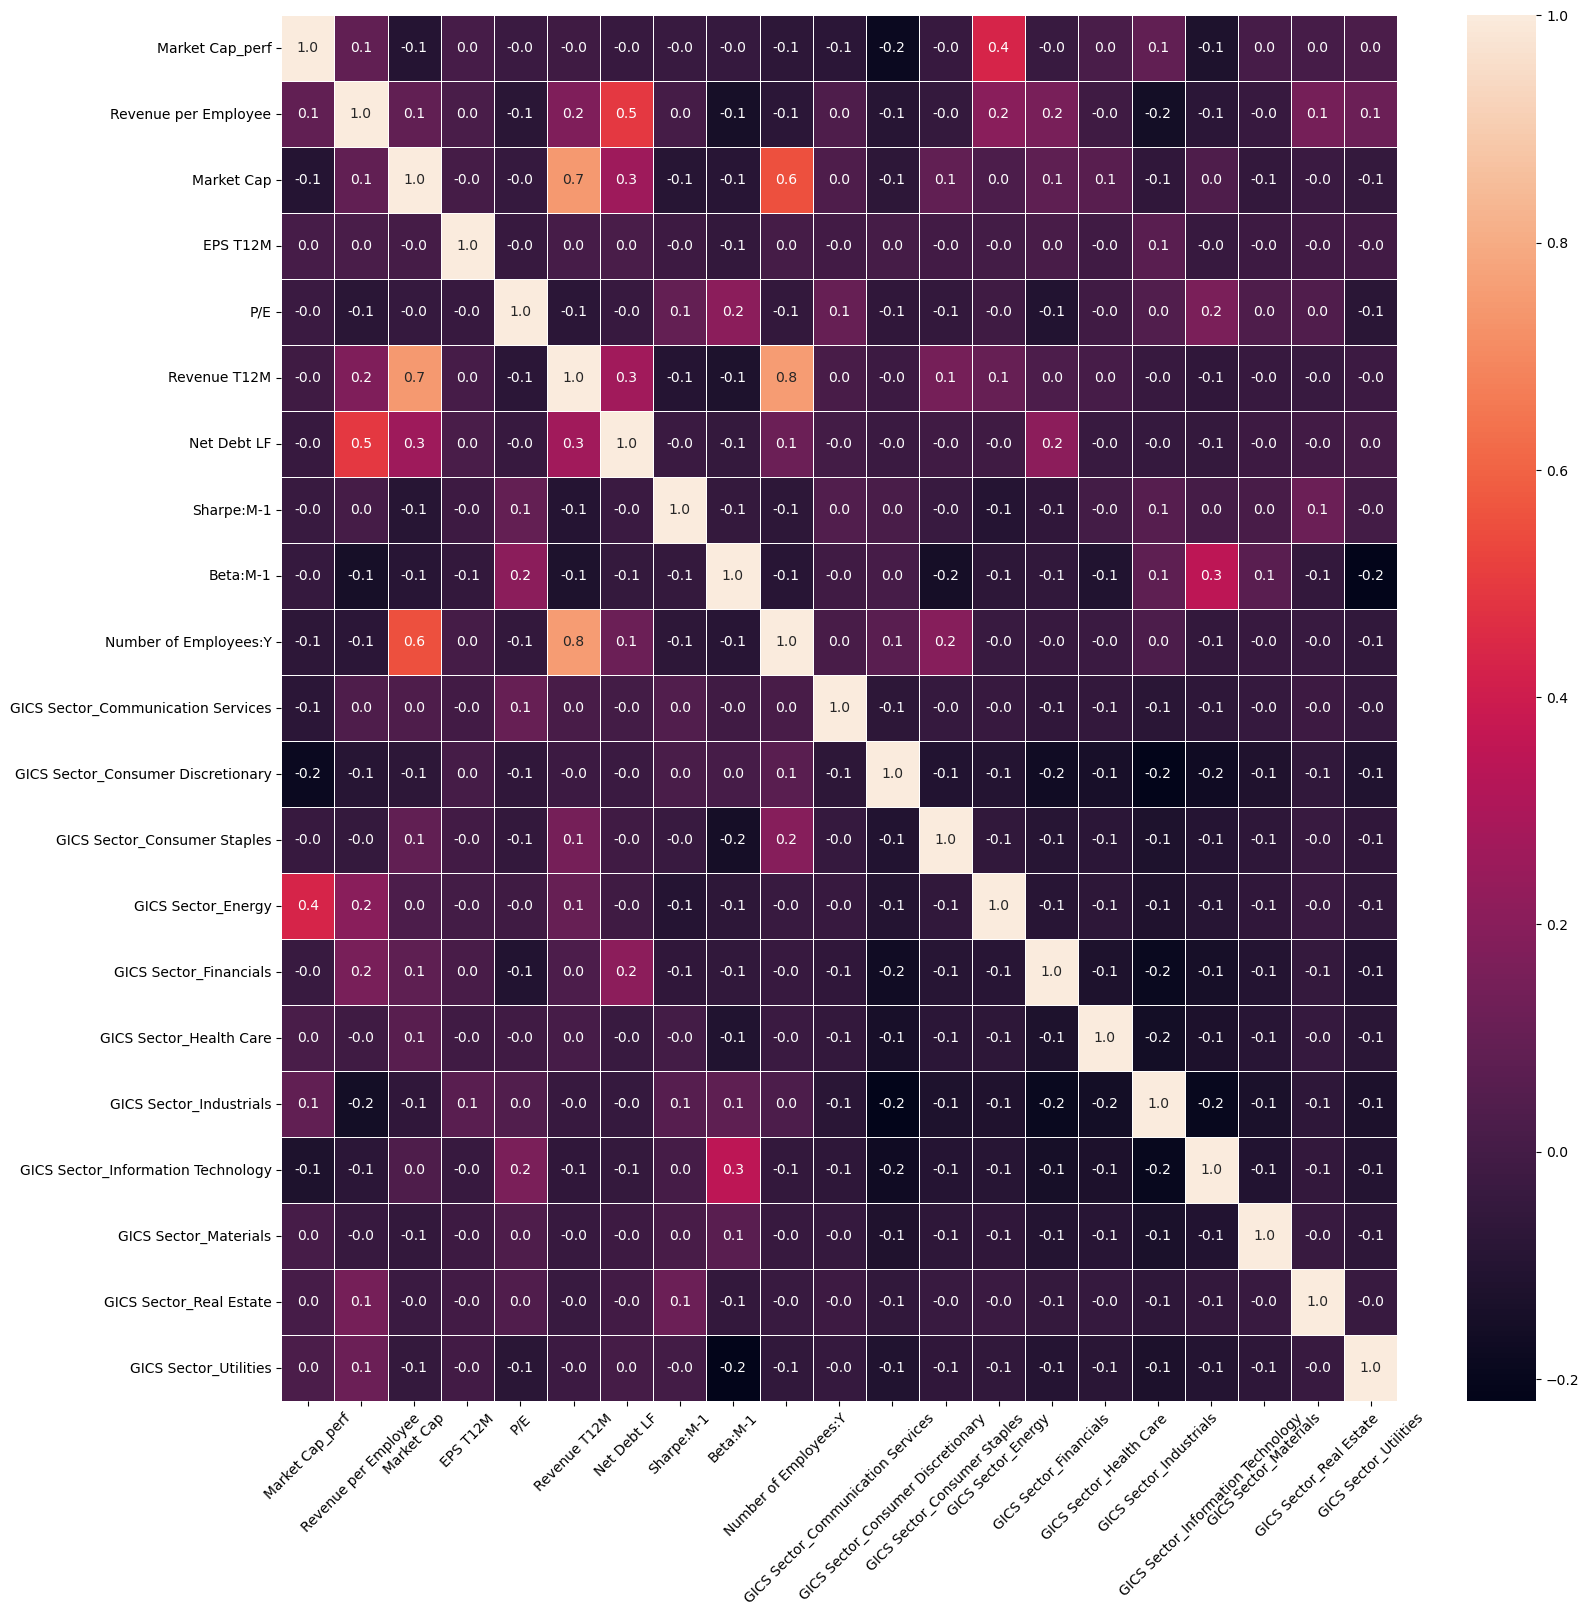


Data decription for cleaned SPR_Period_2.xlsx
Industrials               216
Financials                198
Consumer Discretionary    196
Information Technology    162
Health Care               139
Real Estate                82
Materials                  81
Consumer Staples           65
Utilities                  52
Communication Services     47
Energy                     31
Name: GICS Sector, dtype: int64
       Market Cap_perf  Revenue per Employee     Market Cap      EPS T12M  \
count      1269.000000          1.269000e+03    1269.000000   1269.000000   
mean          0.145752          9.019770e+05   16865.722069     14.815706   
std           0.310371          2.643064e+06   47038.230613    435.462175   
min          -0.839416          2.457104e+04     144.281000    -28.993488   
25%          -0.031057          2.482764e+05    1402.683200      0.940000   
50%           0.138096          3.864179e+05    3528.513100      1.980000   
75%           0.286780          7.353425e+05   12265

C:\Users\lucar\AppData\Local\Temp\ipykernel_12424\676271728.py:11: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



C:\Users\lucar\AppData\Local\Temp\ipykernel_12424\676271728.py:49: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



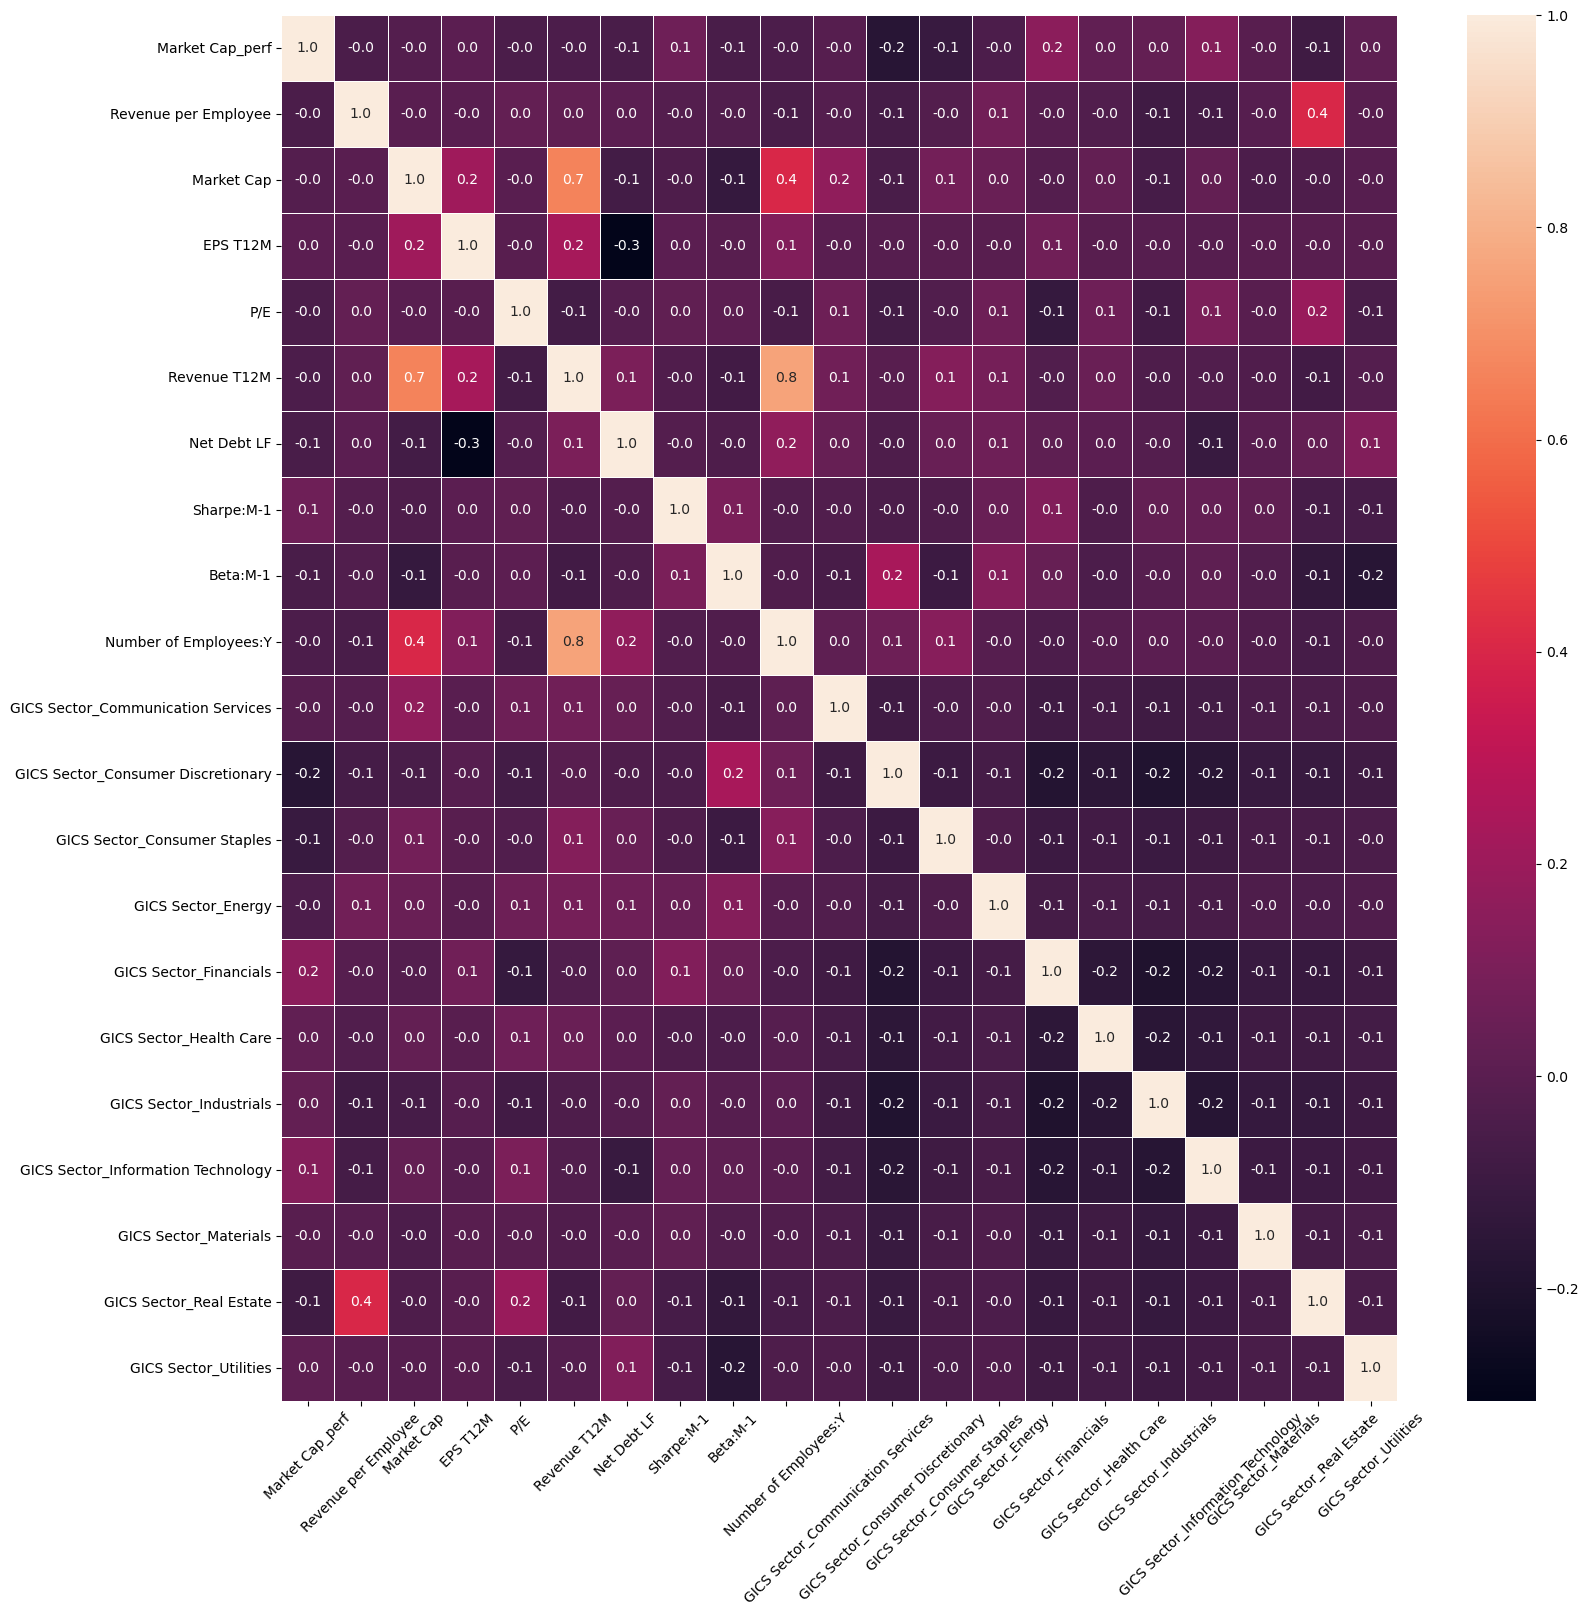


Data decription for cleaned SPR_Period_3.xlsx
Industrials               221
Consumer Discretionary    207
Financials                196
Information Technology    164
Health Care               143
Real Estate                91
Materials                  77
Consumer Staples           65
Utilities                  48
Communication Services     46
Energy                     39
Name: GICS Sector, dtype: int64
       Market Cap_perf  Revenue per Employee     Market Cap      EPS T12M  \
count      1297.000000          1.297000e+03    1297.000000   1297.000000   
mean          0.150803          9.279740e+05   18790.798789     13.130360   
std           0.314666          2.660655e+06   55517.775553    368.214935   
min          -0.882032          2.241154e+04     105.860000    -23.000000   
25%          -0.042641          2.495037e+05    1526.499100      0.970000   
50%           0.102934          4.043673e+05    3917.466100      2.040000   
75%           0.284772          7.870889e+05   13333

C:\Users\lucar\AppData\Local\Temp\ipykernel_12424\676271728.py:11: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



C:\Users\lucar\AppData\Local\Temp\ipykernel_12424\676271728.py:49: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



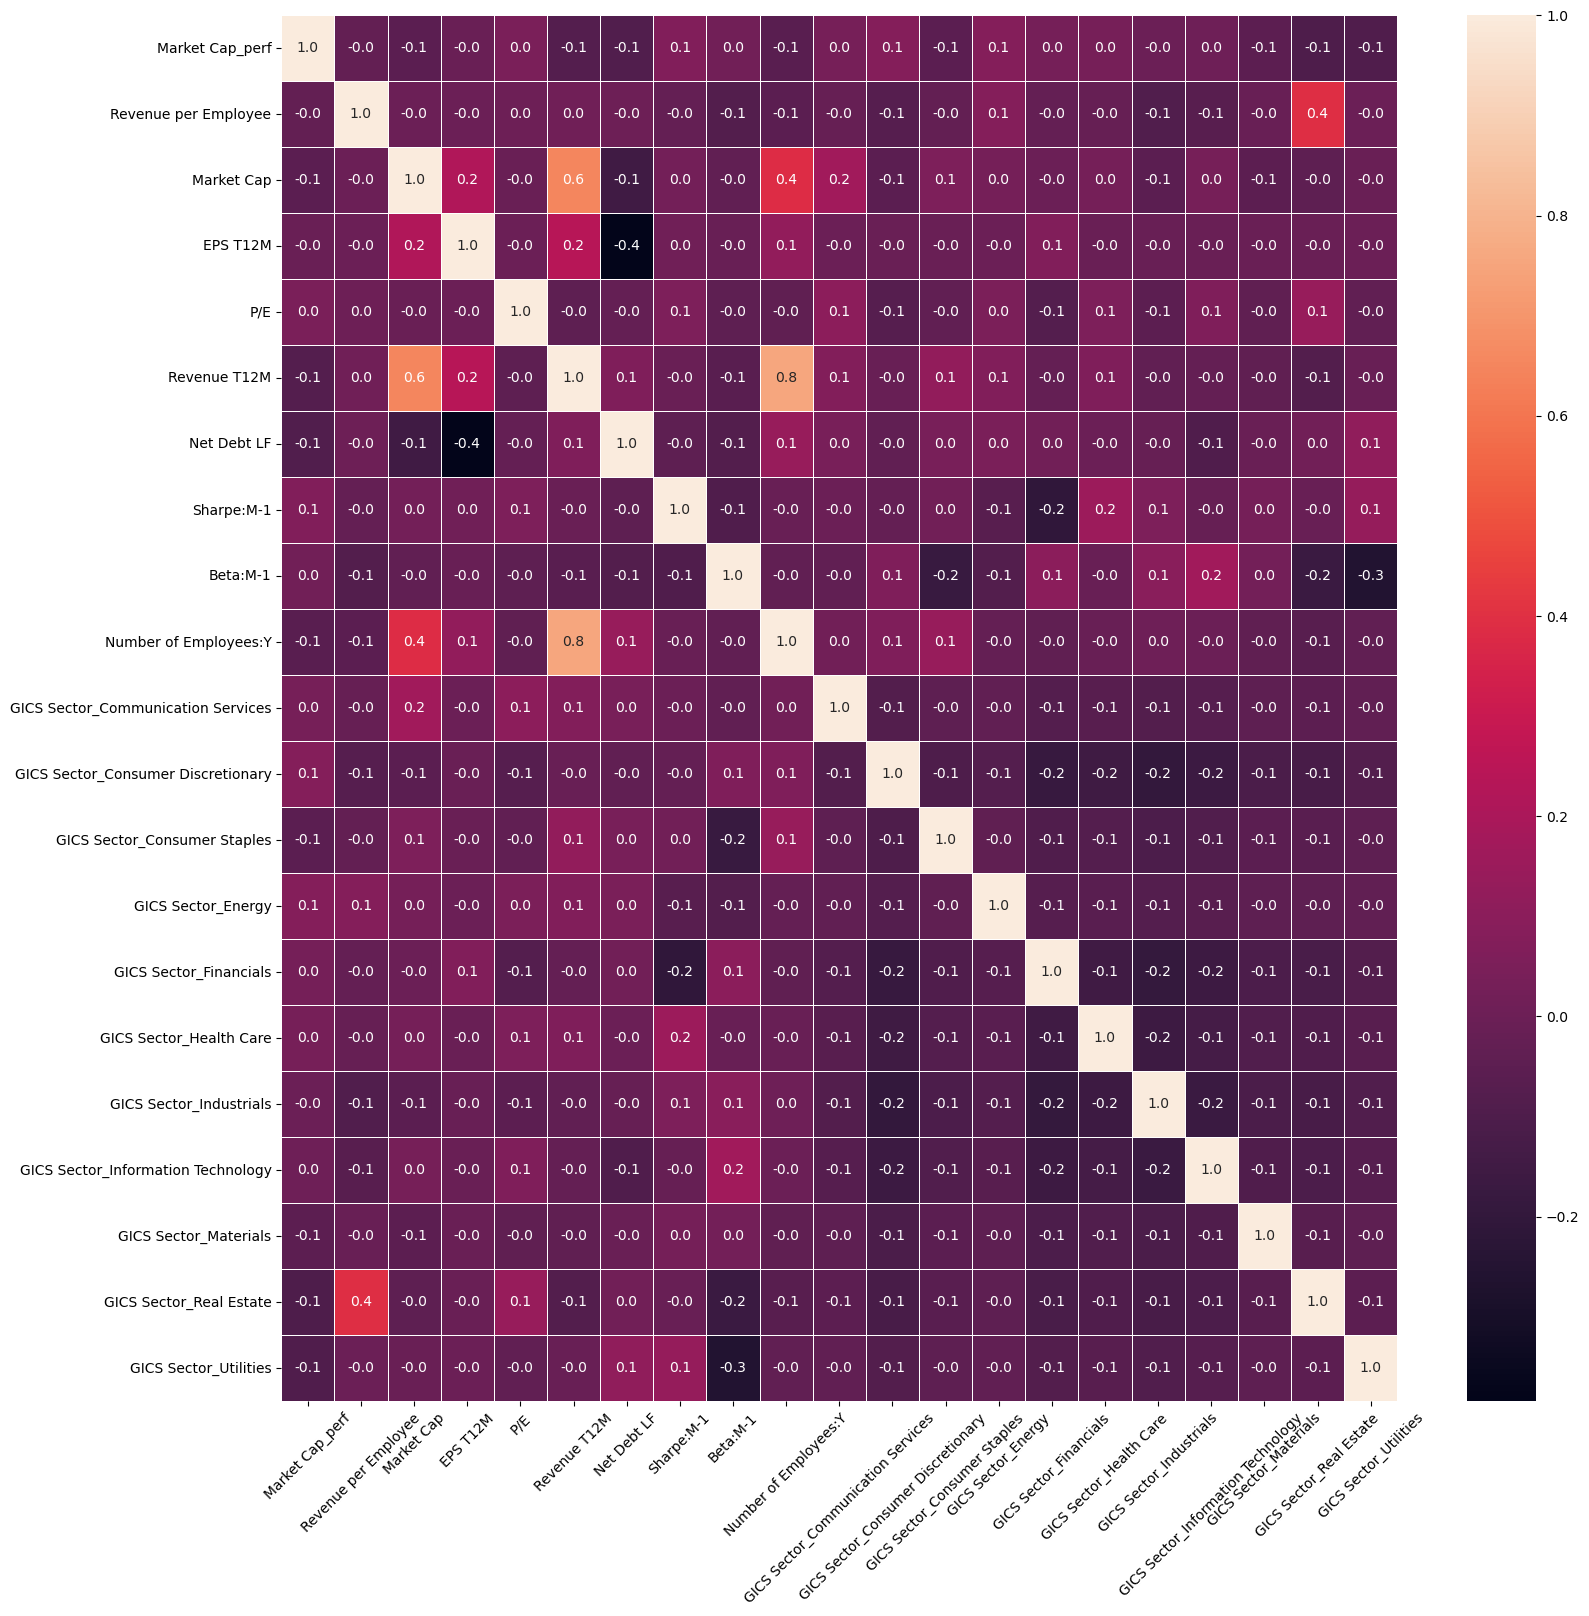


Data decription for cleaned SPR_Period_4.xlsx
Financials                215
Industrials               204
Consumer Discretionary    187
Information Technology    164
Health Care               148
Materials                  77
Real Estate                75
Consumer Staples           73
Utilities                  48
Energy                     43
Communication Services     41
Name: GICS Sector, dtype: int64
       Market Cap_perf  Revenue per Employee    Market Cap      EPS T12M  \
count      1275.000000          1.275000e+03  1.275000e+03   1275.000000   
mean         -0.085932          1.685058e+06  3.707131e+04     49.513641   
std           0.257453          2.441930e+07  1.585613e+05   1569.070283   
min          -0.784052          0.000000e+00  2.625325e+02    -29.999999   
25%          -0.241863          2.872268e+05  2.486165e+03      1.531920   
50%          -0.087754          4.598000e+05  6.115007e+03      3.340000   
75%           0.048259          9.516280e+05  2.262540e+04 

C:\Users\lucar\AppData\Local\Temp\ipykernel_12424\676271728.py:11: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



C:\Users\lucar\AppData\Local\Temp\ipykernel_12424\676271728.py:49: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



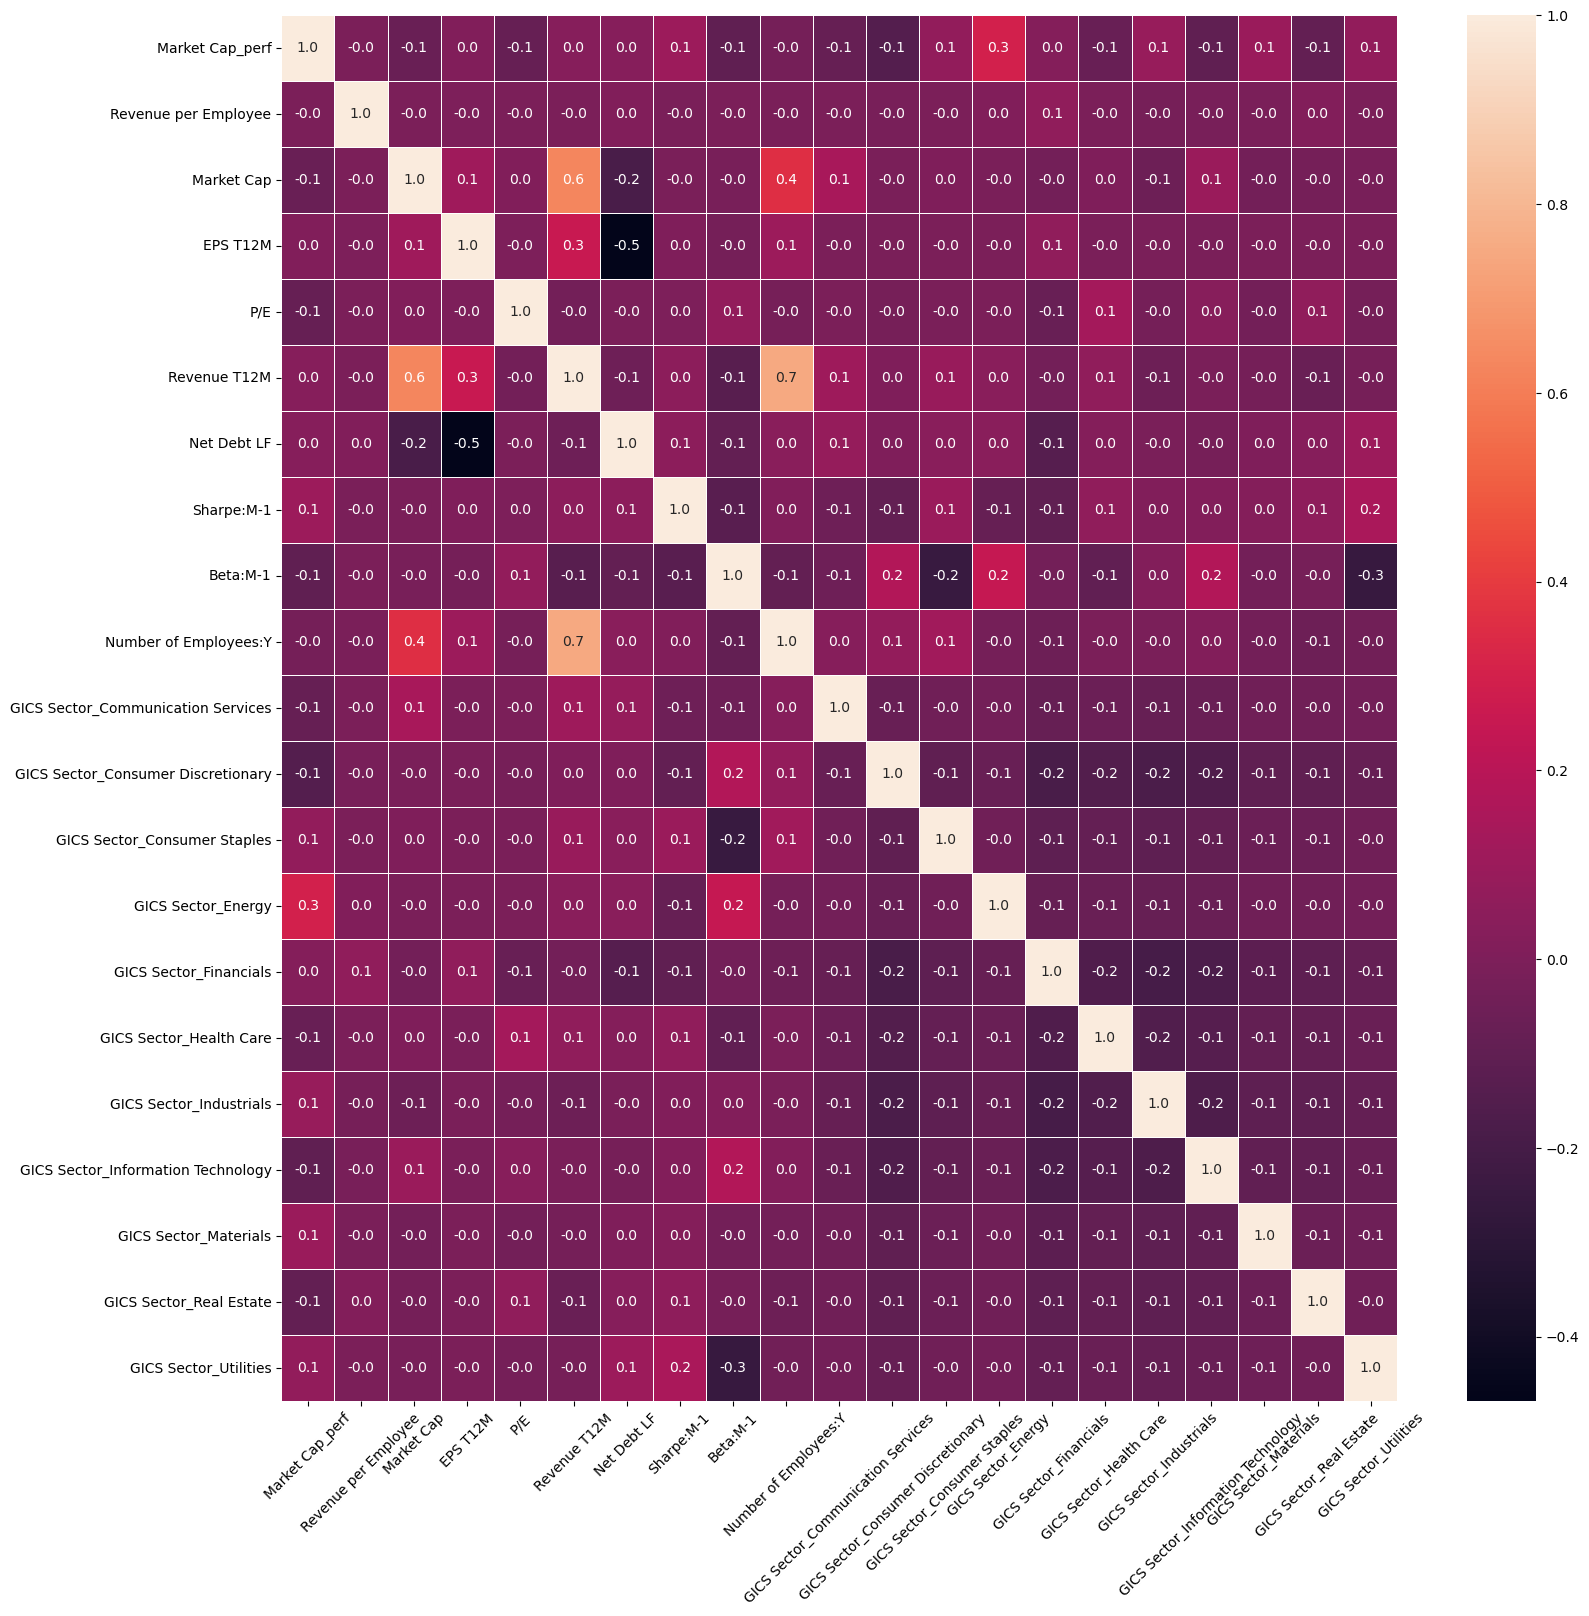

In [24]:
P1 = df('SPR_Period_1.xlsx')
P1.to_pickle("data/P1.pkl")
P2 = df('SPR_Period_2.xlsx')
P2.to_pickle("data/P2.pkl")
P3 = df('SPR_Period_3.xlsx')
P3.to_pickle("data/P3.pkl")
CrP = df('SPR_Period_4.xlsx')
CrP.to_pickle("data/CrP.pkl")


In [25]:
# saving the pre-processed dfs for easy access

P1 = pd.read_pickle("data/P1.pkl")
P2 = pd.read_pickle("data/P2.pkl")
P3 = pd.read_pickle("data/P3.pkl")
CrP = pd.read_pickle("data/CrP.pkl")



Data description for all periods (including current period)
Industrials               786
Consumer Discretionary    710
Financials                703
Information Technology    588
Health Care               499
Materials                 286
Real Estate               262
Consumer Staples          247
Utilities                 195
Communication Services    156
Energy                    153
Name: GICS Sector, dtype: int64
       Market Cap_perf  Revenue per Employee    Market Cap      EPS T12M  \
count      4585.000000          4.585000e+03  4.585000e+03   4585.000000   
mean          0.106815          1.053242e+06  2.225018e+04     21.984615   
std           0.400440          1.303506e+07  9.342407e+04    880.559905   
min          -0.916199          0.000000e+00  1.058600e+02    -29.999999   
25%          -0.114696          2.424133e+05  1.562940e+03      1.030000   
50%           0.056103          3.851755e+05  4.102253e+03      2.120000   
75%           0.254865          7.495073e+05 

C:\Users\lucar\AppData\Local\Temp\ipykernel_12424\1014206869.py:24: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



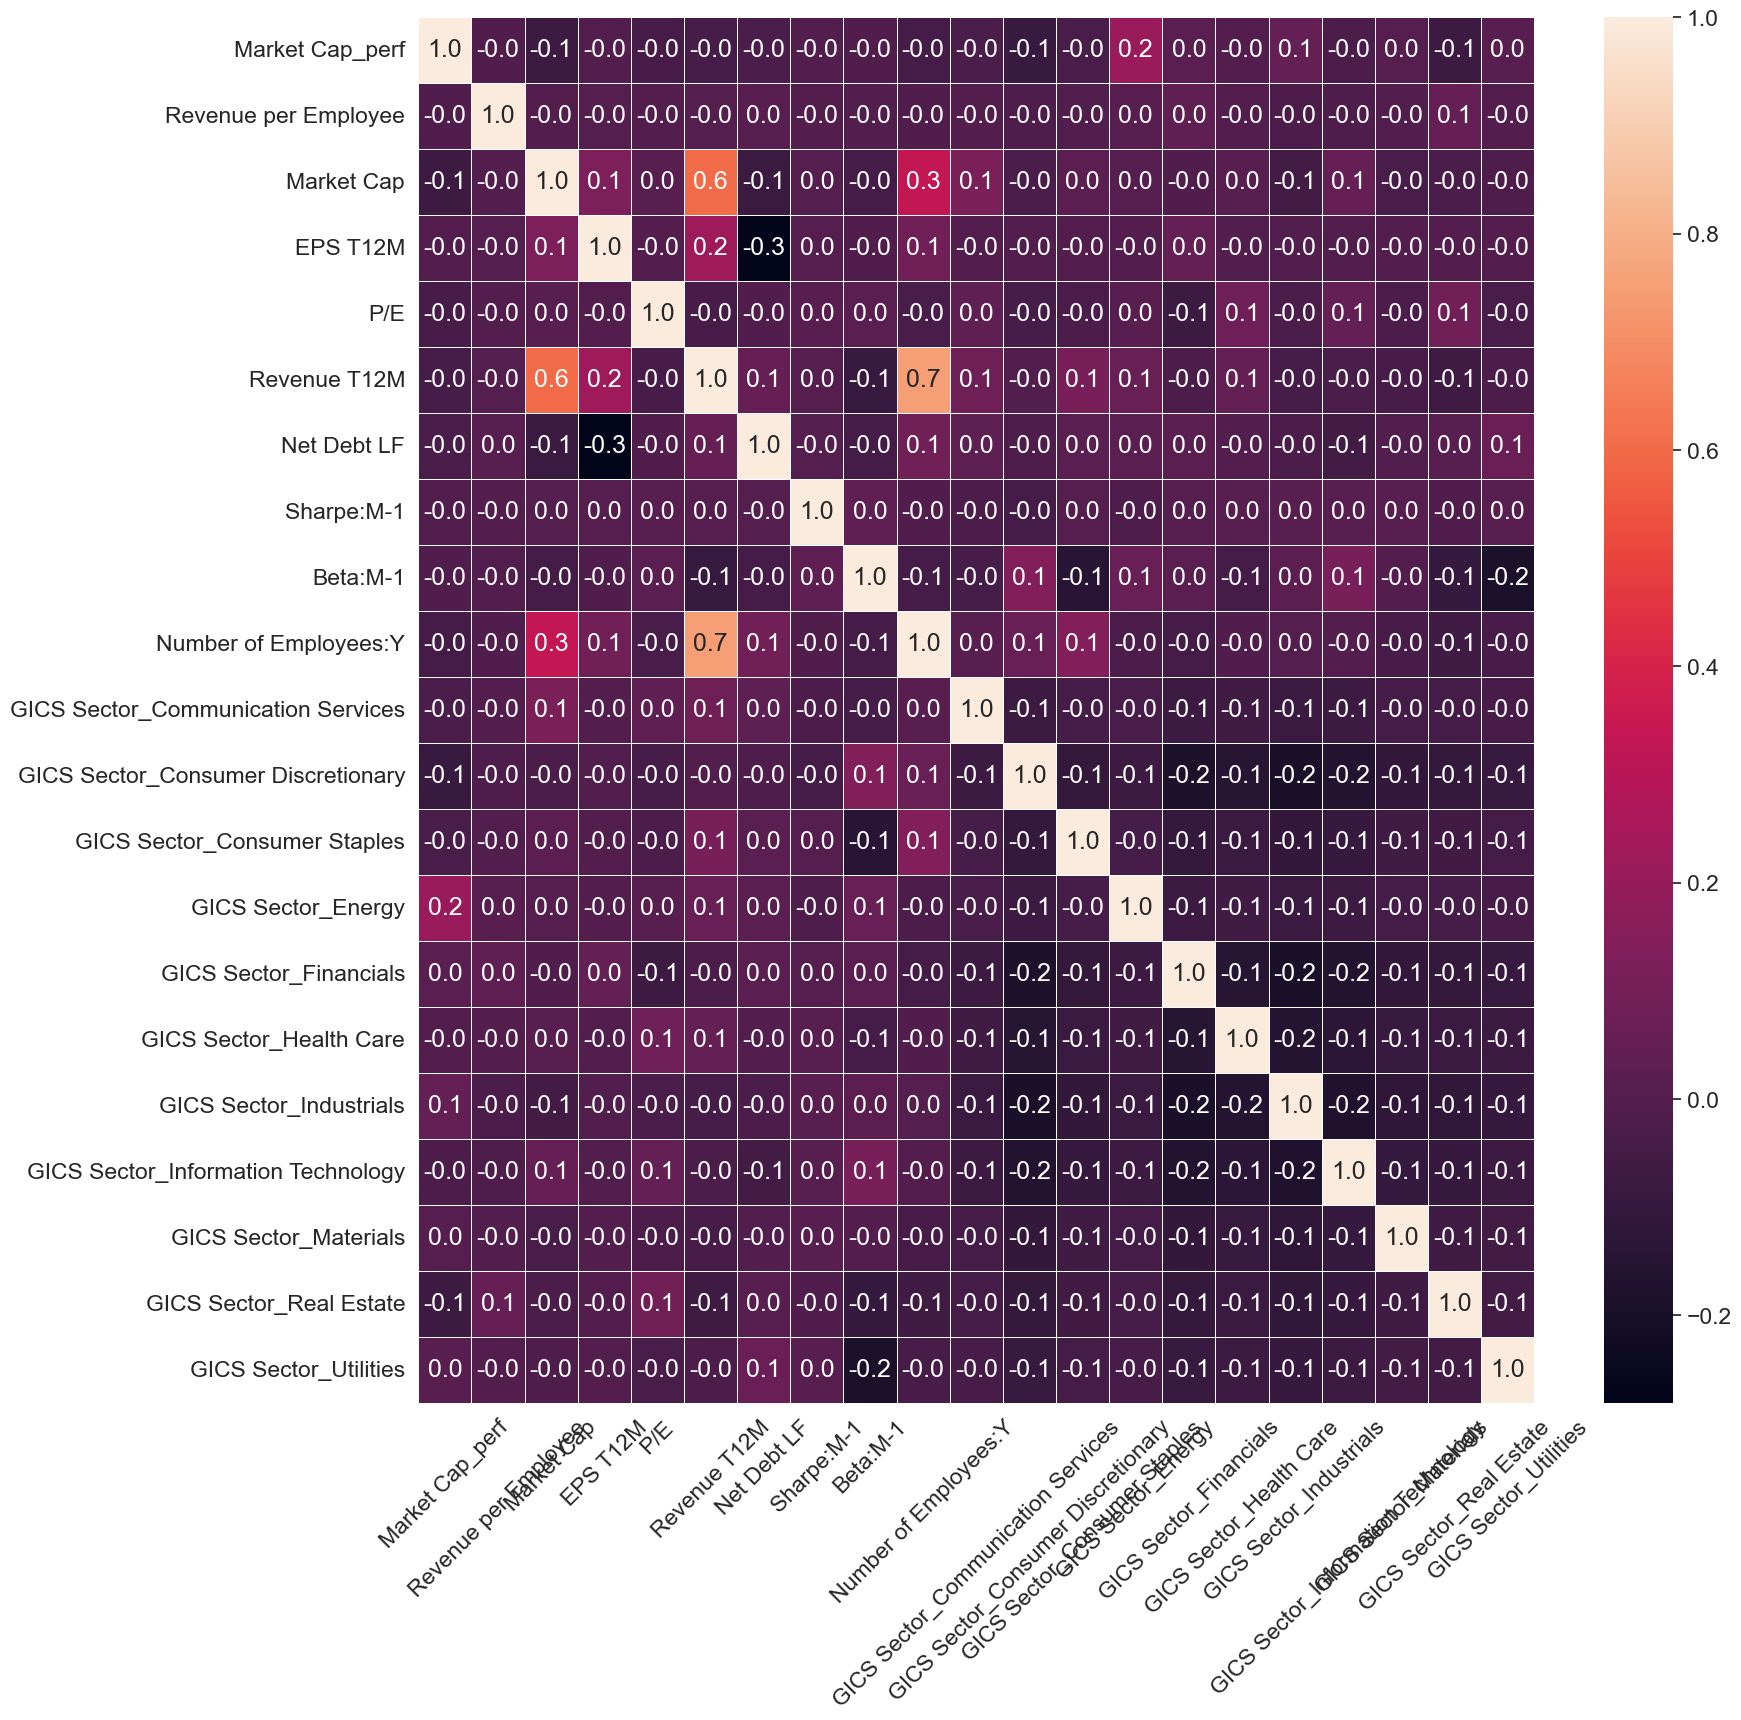

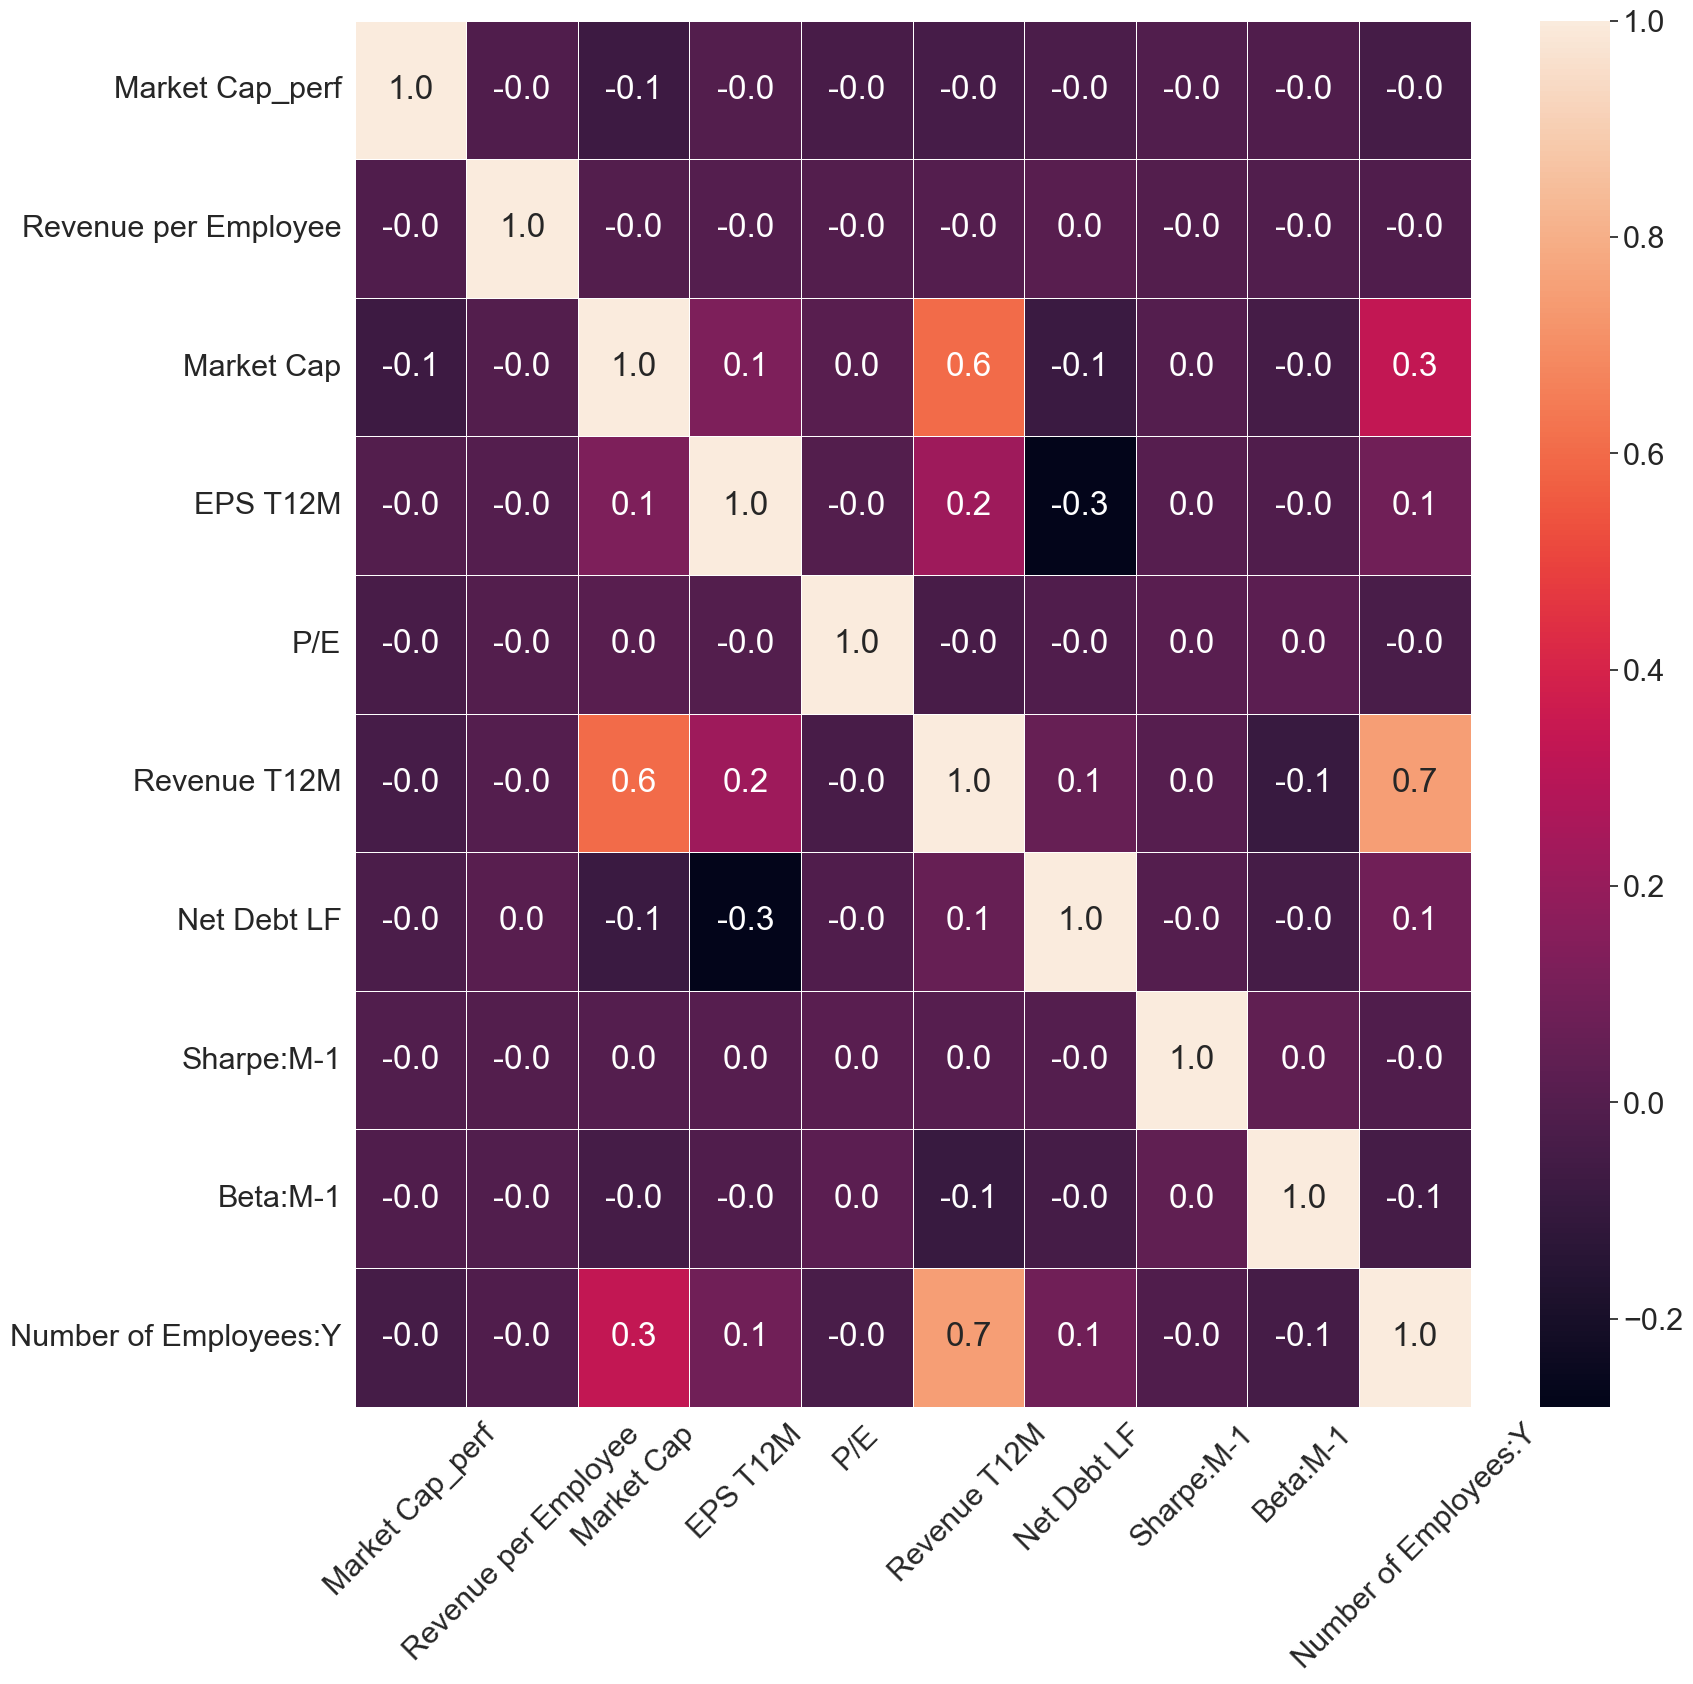

In [54]:
# creating a dataframe consisting of all data across periods
all_dfs = [P1, P2, P3, CrP]
all_df = pd.concat(all_dfs)

print("\nData description for all periods (including current period)")
perf = all_df.pop("Market Cap_perf")
all_df.insert(0, "Market Cap_perf", perf)

rpe = all_df.pop("Revenue per Employee")
all_df.insert(1, "Revenue per Employee", rpe)

print(all_df["GICS Sector"].value_counts(ascending=False))
print(all_df.iloc[:, :12].describe())

fig = px.scatter(all_df, x="Beta:M-1",
                 y="Market Cap_perf",
                 size="Market Cap",
                 color='GICS Sector',
                 title="ALL DATA: Risk/Compared Volatility to SP1500 compared to Return/Performance for single companies",
                 hover_name="Name", log_x=True, size_max=100,  width=1200, height=600)

fig.show()

grouped = all_df.groupby("GICS Sector").mean()
fig = px.scatter(grouped, x="Beta:M-1",
                 y="Market Cap_perf",
                 size="Market Cap",
                 title="ALL DATA: Risk/Compared Volatility to SP1500 compared to Return/Performance by GICS Sector",
                 color="Market Cap_perf", hover_name=grouped.index, log_x=True, size_max=100, width=1200, height=600)
fig.show()

heatmap(all_df)
heatmap(all_df.iloc[:, :12])



Data decription for only former periods
Industrials               582
Consumer Discretionary    523
Financials                488
Information Technology    424
Health Care               351
Materials                 209
Real Estate               187
Consumer Staples          174
Utilities                 147
Communication Services    115
Energy                    110
Name: GICS Sector, dtype: int64
       Market Cap_perf  Revenue per Employee     Market Cap      EPS T12M  \
count      3310.000000          3.310000e+03    3310.000000   3310.000000   
mean          0.181060          8.098693e+05   16541.132647     11.380534   
std           0.420463          2.363555e+06   47896.088008    354.765218   
min          -0.916199          2.241154e+04     105.860000    -28.993488   
25%          -0.045230          2.300026e+05    1401.645550      0.912500   
50%           0.130913          3.599069e+05    3471.415900      1.860000   
75%           0.315884          6.920711e+05   11867.86065

C:\Users\lucar\AppData\Local\Temp\ipykernel_12424\3846090756.py:24: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



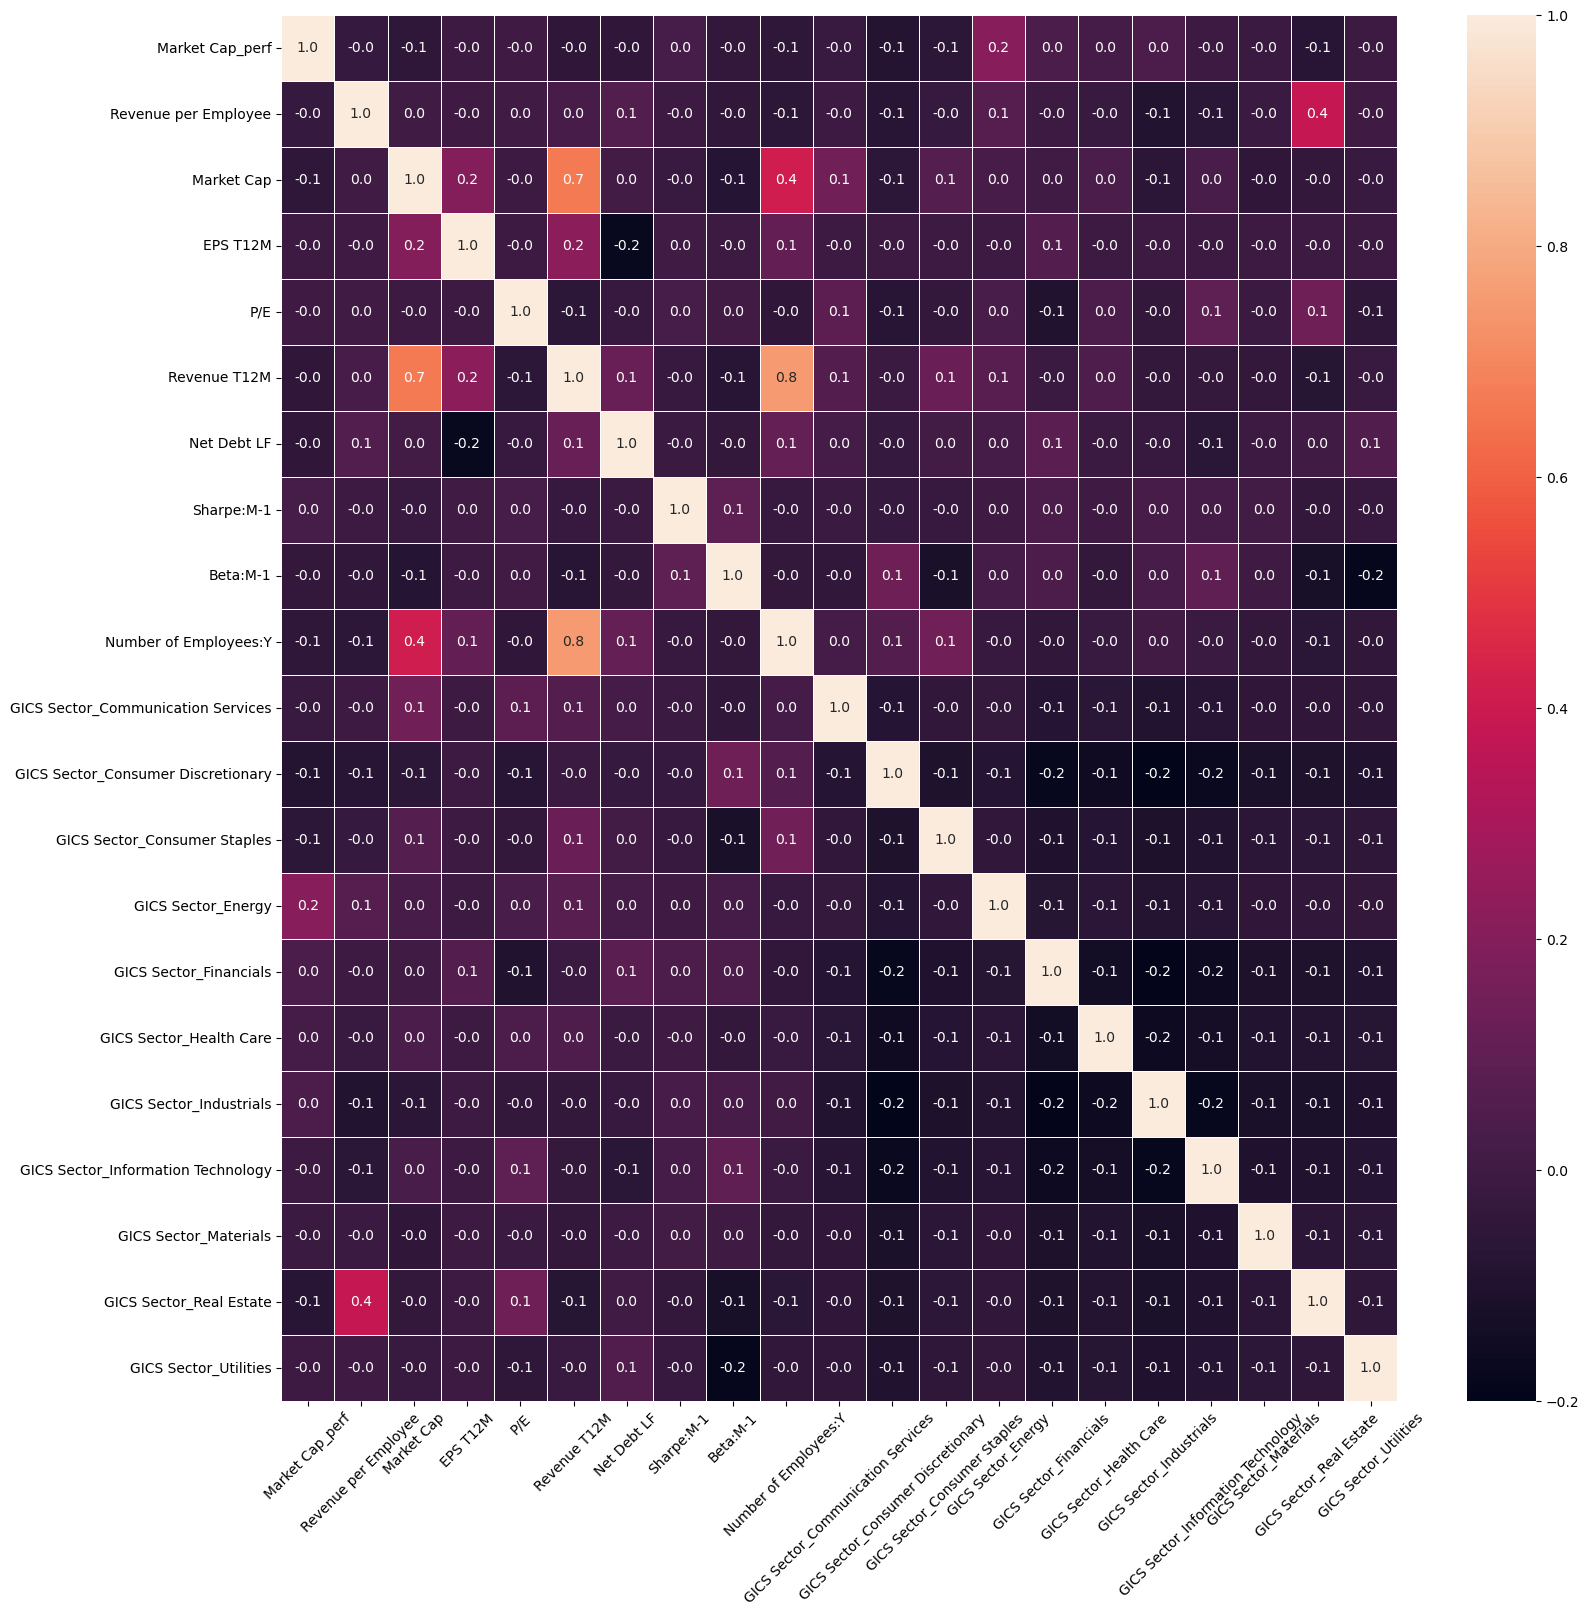

In [27]:
# creating a df consisting only of concluded periods

former_dfs = [P1, P2, P3]
former_df = pd.concat(former_dfs)

print("\nData decription for only former periods")
perf = former_df.pop("Market Cap_perf")
former_df.insert(0, "Market Cap_perf", perf)

rpe = former_df.pop("Revenue per Employee")
former_df.insert(1, "Revenue per Employee", rpe)

print(former_df["GICS Sector"].value_counts(ascending=False))
print(former_df.iloc[:, :12].describe())

fig = px.scatter(former_df, x="Beta:M-1", y="Market Cap_perf",
                 size="Market Cap",
                 title="FORMER DATA: Risk/Compared Volatility to SP1500 compared to Return/Performance for single companies",
                 color='GICS Sector',
                 hover_name="Name", log_x=True, size_max=100,  width=1200, height=600)

fig.show()

grouped = former_df.groupby("GICS Sector").mean()
fig = px.scatter(grouped, x="Beta:M-1", y="Market Cap_perf", size="Market Cap",
                 title="FORMER DATA: Risk/Compared Volatility to SP1500 compared to Return/Performance by GICS Sector",
                 
                 color="Market Cap_perf", hover_name=grouped.index, log_x=True, size_max=100, width=1200, height=600)
fig.show()

heatmap(former_df)


Energy                    5
Industrials               5
Consumer Discretionary    5
Health Care               4
Financials                4
Information Technology    3
Materials                 2
Communication Services    1
Consumer Staples          1
Name: GICS Sector, dtype: int64
       Market Cap_perf  Revenue per Employee    Market Cap   EPS T12M  \
count        30.000000          3.000000e+01     30.000000  30.000000   
mean          2.280571          5.911873e+05   3358.930623   1.247556   
std           0.977822          4.769266e+05   6469.283667   2.205376   
min           1.308081          1.006522e+05    245.865200  -6.720000   
25%           1.500476          2.704801e+05    473.586450   0.437500   
50%           1.992901          4.660659e+05   1135.774550   0.978333   
75%           2.539989          8.024246e+05   2422.908625   1.982500   
max           5.033335          2.353037e+06  33785.250000   5.600000   

              P/E  Revenue T12M   Net Debt LF  Sharpe:M-1 

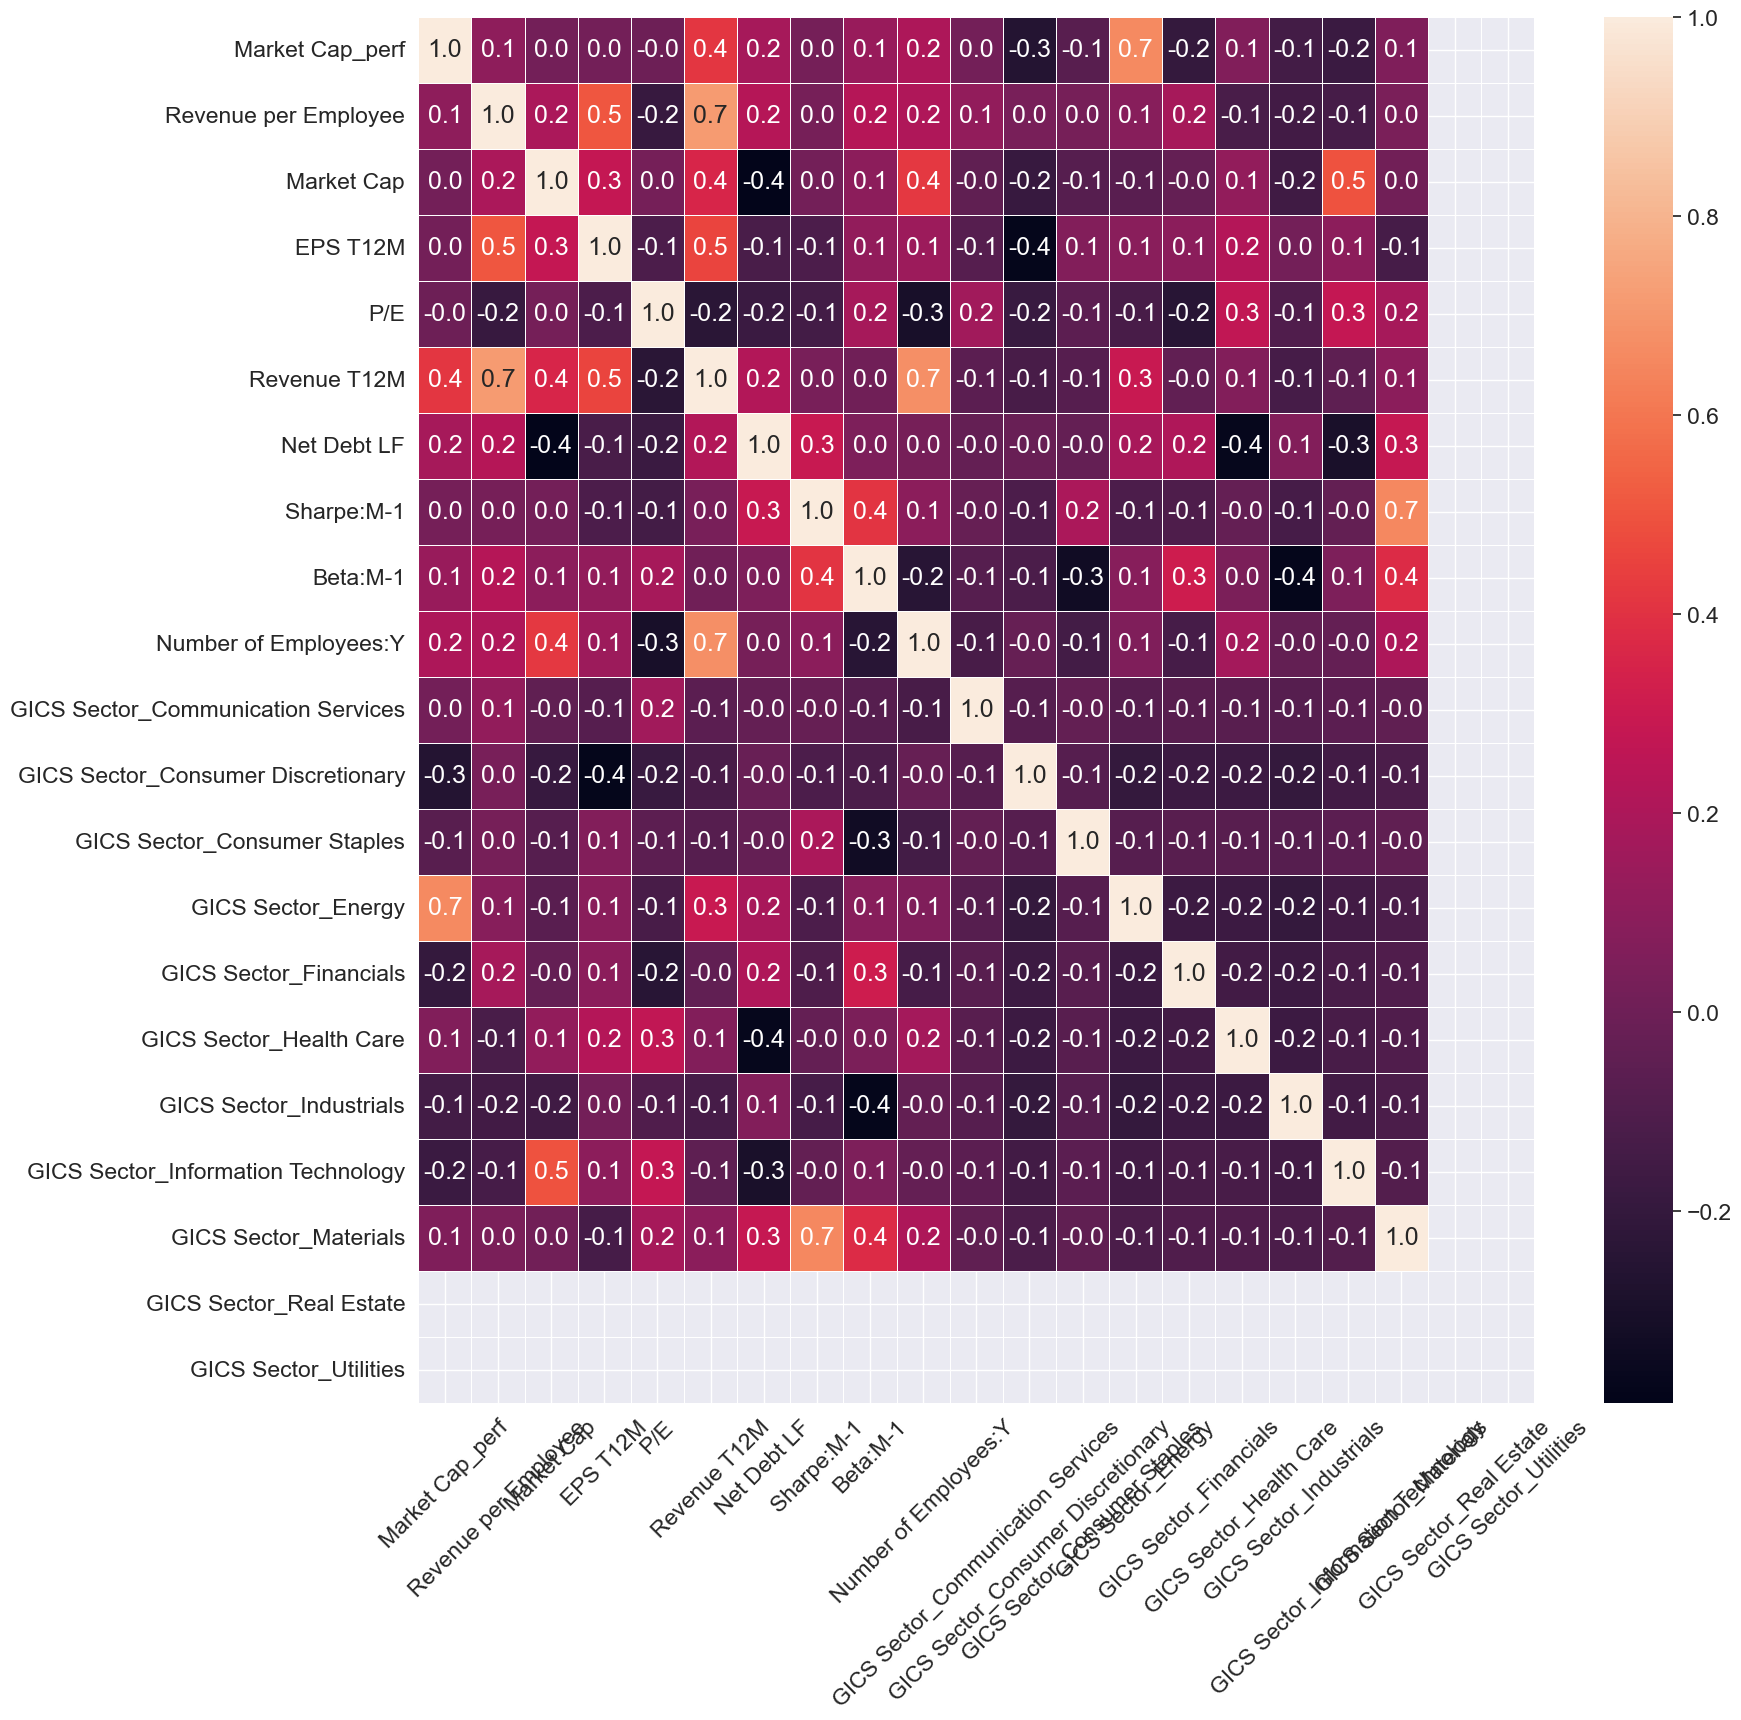

In [29]:
# insight into the characteristics of the best performing observations

top10 = pd.DataFrame()

for df in former_dfs:
    top10 = pd.concat([top10, df.sort_values(
        "Market Cap_perf", ascending=False).head(10)])

perf = top10.pop("Market Cap_perf")
top10.insert(0, "Market Cap_perf", perf)

rpe = top10.pop("Revenue per Employee")
top10.insert(1, "Revenue per Employee", rpe)

print(top10["GICS Sector"].value_counts(ascending=False))
print(top10.iloc[:, :12].describe())

top10.sort_values("Market Cap_perf", ascending=False)

heatmap(top10)


## 3. Machine learning

### Basic Decision Tree

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score

# function to quickly retrieve minimal evaluation data for the classifier

def evaluate(clf, X_train, X_test, y_train, y_test):
    print("Train Accuracy :", accuracy_score(y_train, clf.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, clf.predict(X_train)))
    print("Test Accuracy :", accuracy_score(y_test, clf.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, clf.predict(X_test)))


In [74]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


def decision_tree(df, title):
    df["Compared Performance"] = np.where(
        (df['Market Cap_perf'] > df['Market Cap_perf'].mean()), "Outperformed", "Not Outperformed")
    y = df["Compared Performance"]
    X = df.drop(
        columns=["Compared Performance", "Market Cap_perf", "Name", "GICS Sector"])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42)

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.countplot(x="Compared Performance", data=df)
    plt.title("Target distribution")
    plt.show()

    print(f'X_train : {X_train.shape}')
    print(f'y_train : {y_train.shape}')
    print(f'X_test : {X_test.shape}')
    print(f'y_test : {y_test.shape}')

    print(title)
    dt = DecisionTreeClassifier(max_depth=2)

    dt.fit(X_train, y_train)

    fig, ax = plt.subplots(figsize=(30, 30))
    plot_tree(dt, feature_names=X.columns, class_names=[
              "Outperformed", "Not Outperformed"], filled=True,  proportion=False, fontsize=35)

    evaluate(dt, X_train, X_test, y_train, y_test)


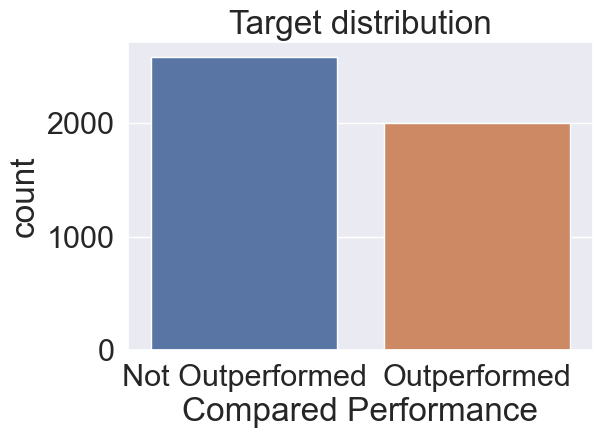

X_train : (4126, 20)
y_train : (4126,)
X_test : (459, 20)
y_test : (459,)
Using the data of all periods (including the current, ongoing one)
Train Accuracy : 0.5843431895298109
Train Confusion Matrix:
[[1362  956]
 [ 759 1049]]
Test Accuracy : 0.5490196078431373
Test Confusion Matrix:
[[146 119]
 [ 88 106]]


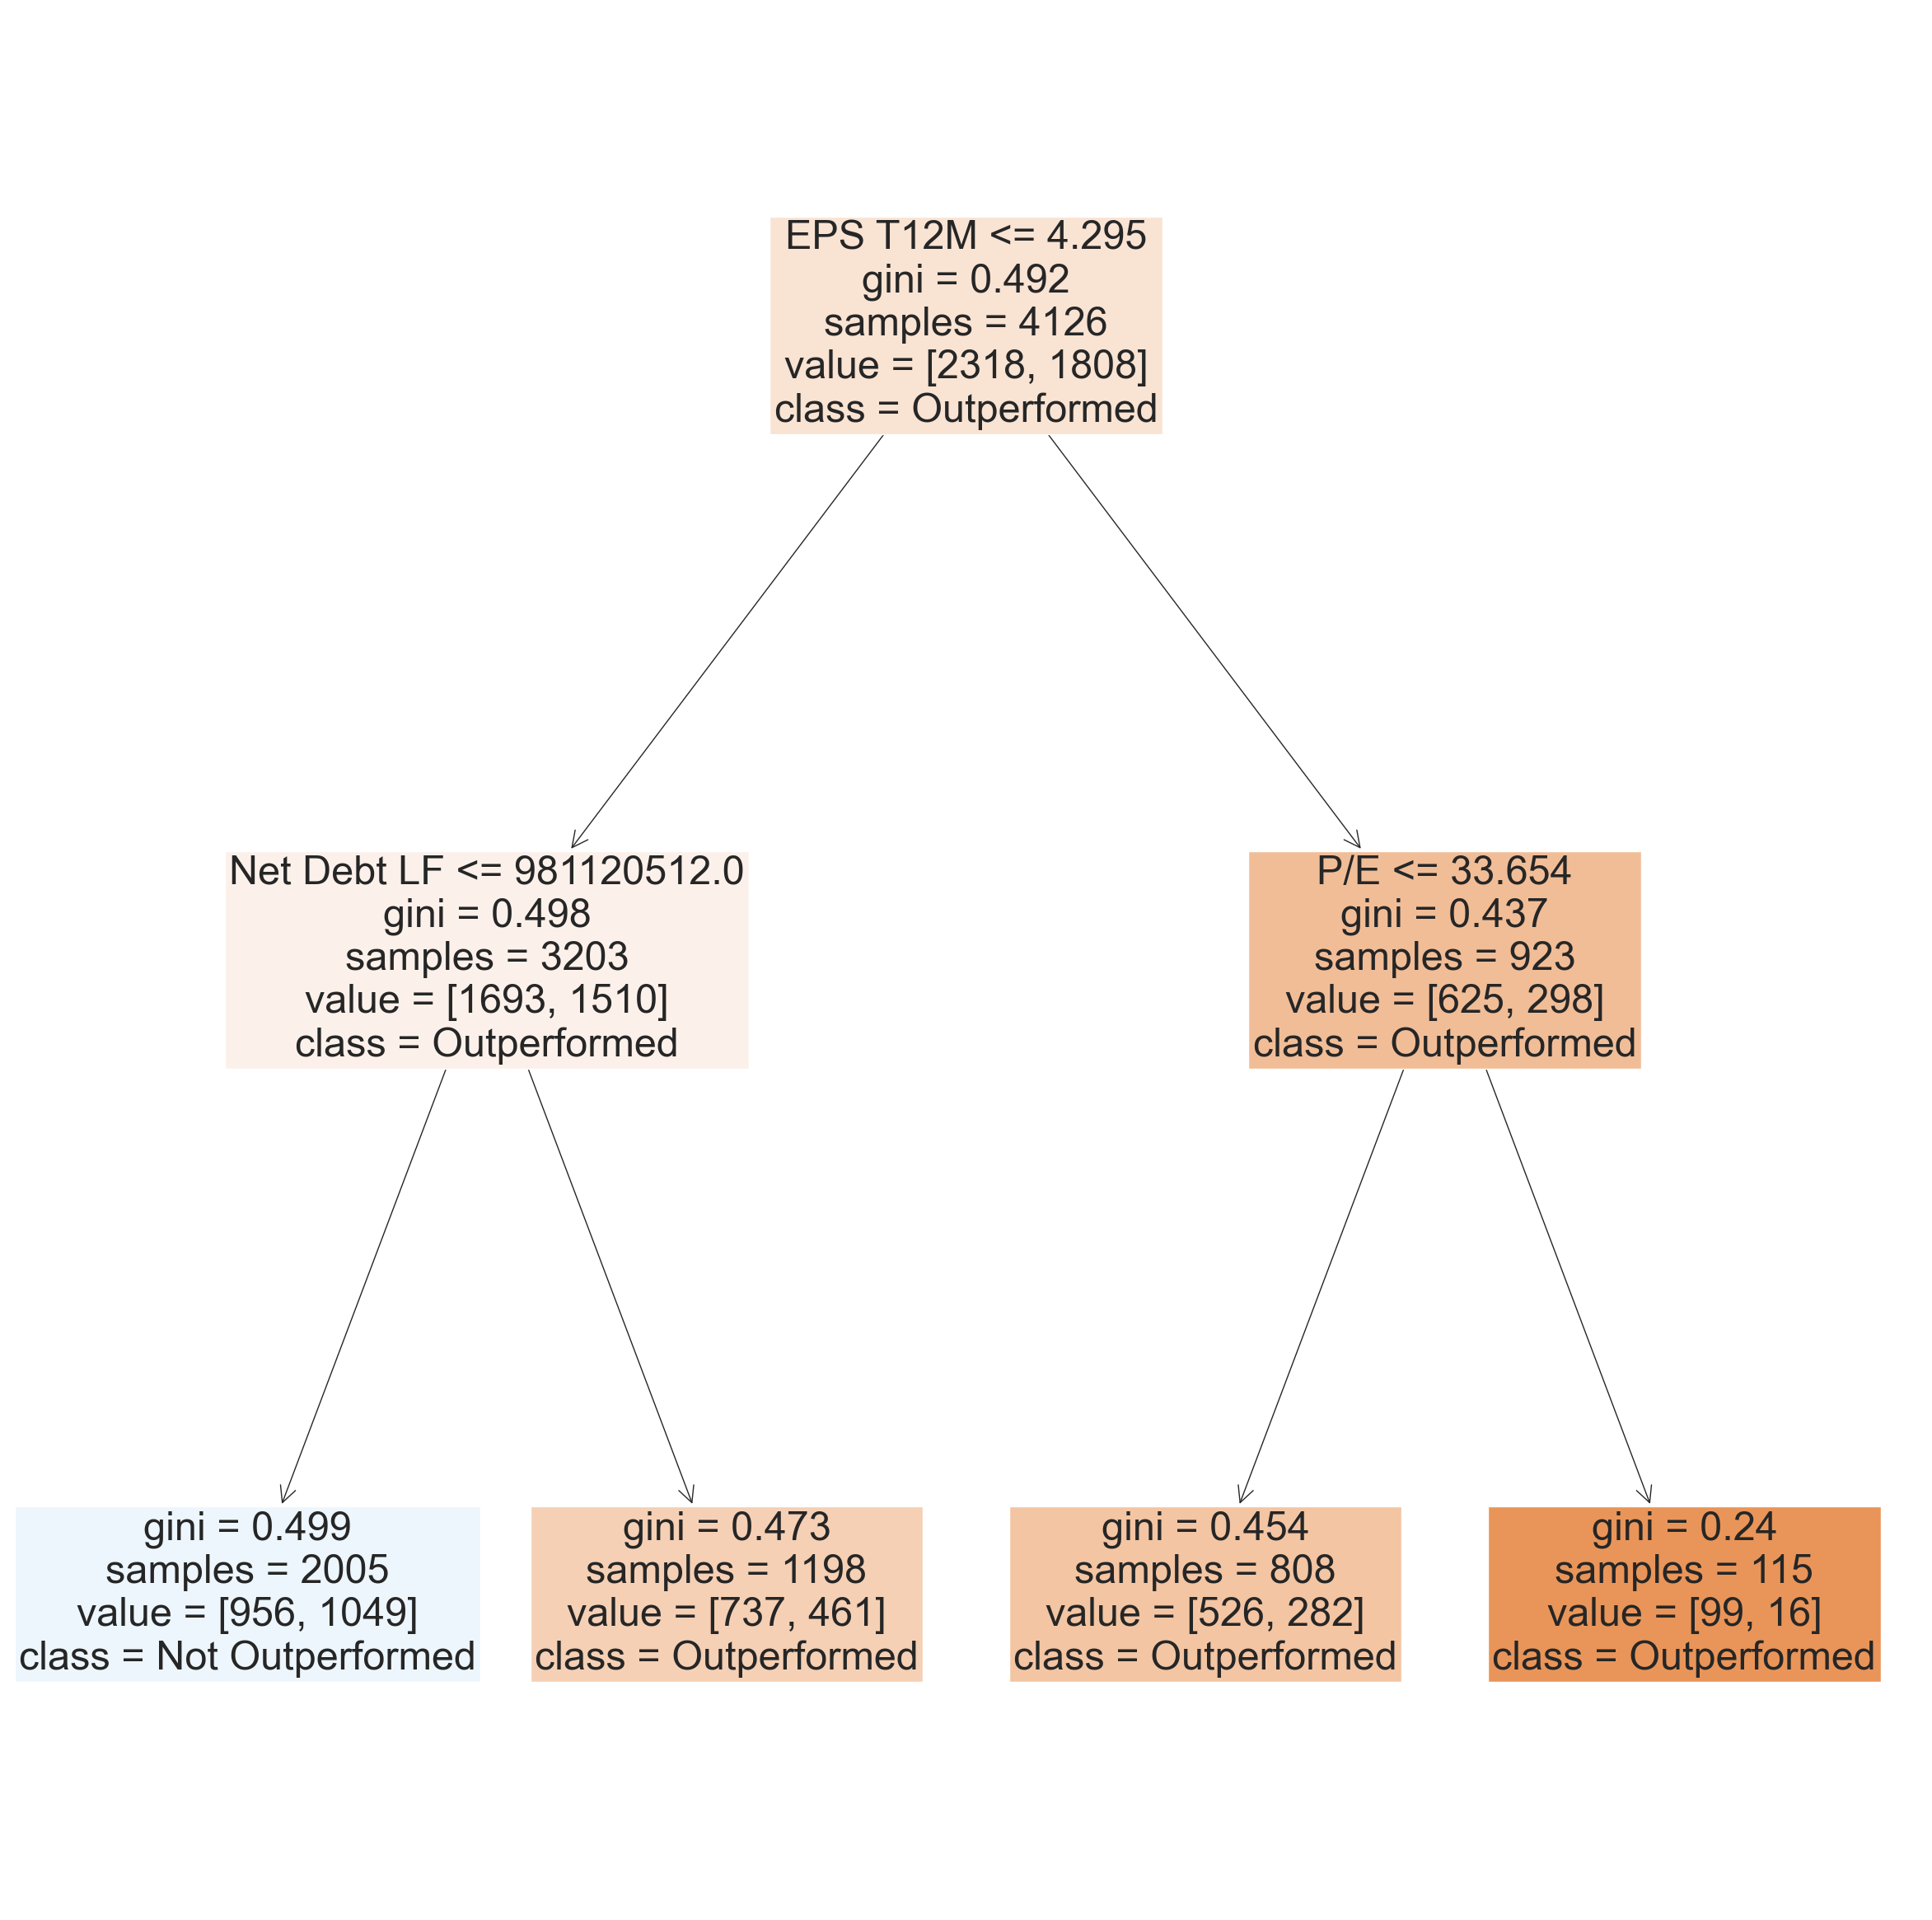

In [77]:
decision_tree(
    all_df, "Using the data of all periods (including the current, ongoing one)")


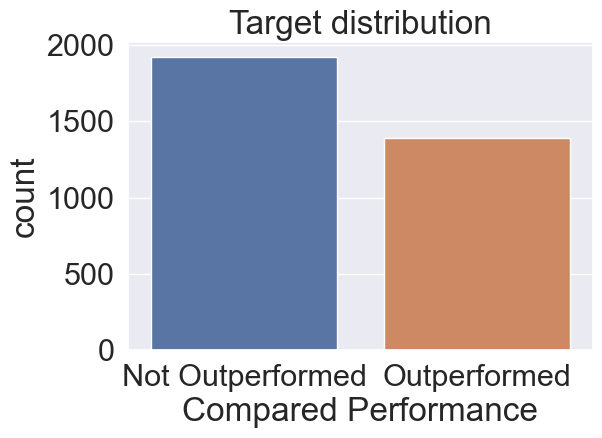

X_train : (2979, 20)
y_train : (2979,)
X_test : (331, 20)
y_test : (331,)
Using the data of only concluded periods
Train Accuracy : 0.5793890567304465
Train Confusion Matrix:
[[1726    0]
 [1253    0]]
Test Accuracy : 0.5891238670694864
Test Confusion Matrix:
[[195   0]
 [136   0]]


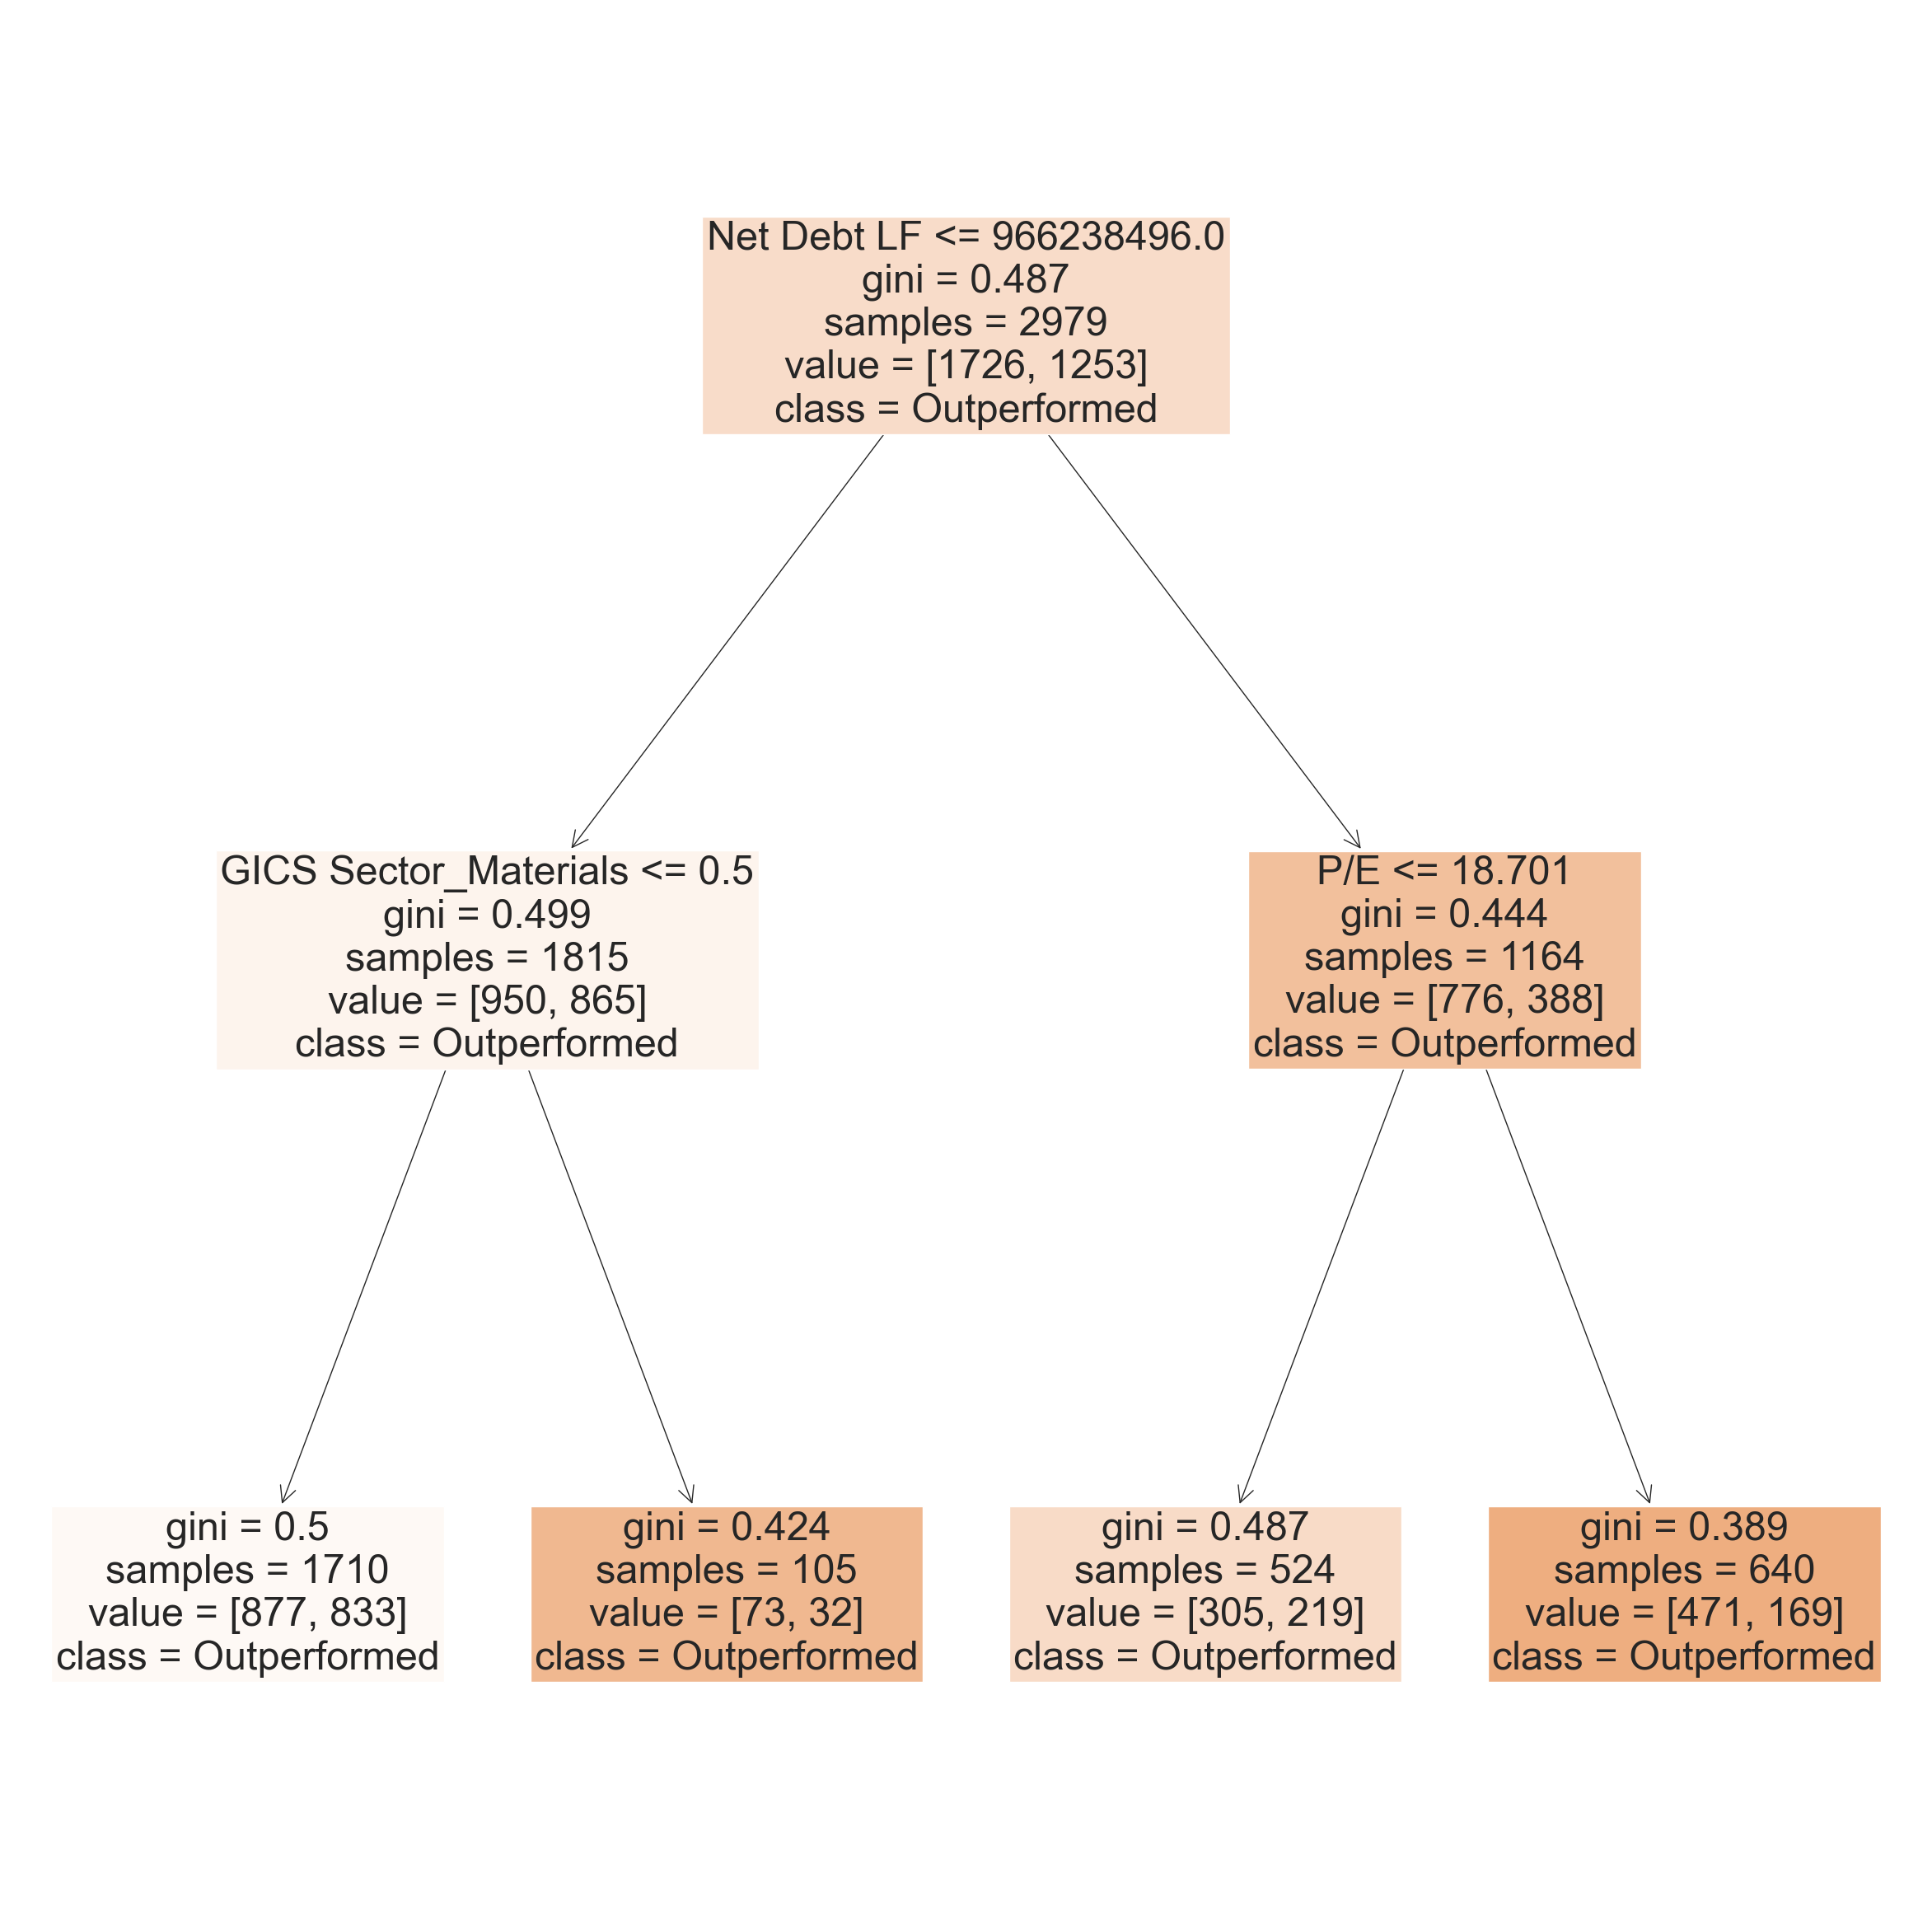

In [76]:
decision_tree(former_df, "Using the data of only concluded periods")


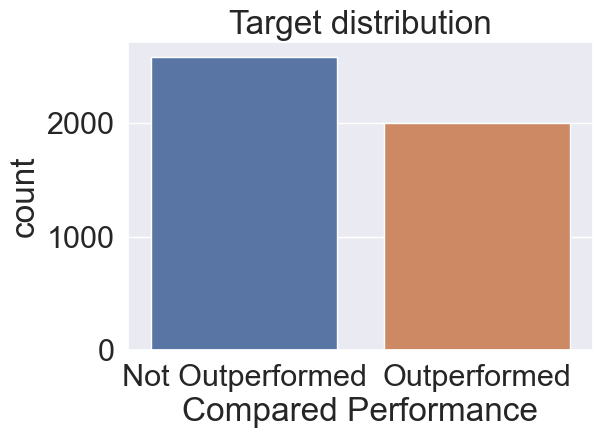

X_train : (3310, 20)
y_train : (3310,)
X_test : (1275, 20)
y_test : (1275,)
Using the data of concluded periods as training data and the current, ongoing period data, as test data
Train Accuracy : 0.592749244712991
Train Confusion Matrix:
[[1565  356]
 [ 992  397]]
Test Accuracy : 0.5090196078431373
Test Confusion Matrix:
[[567  75]
 [551  82]]


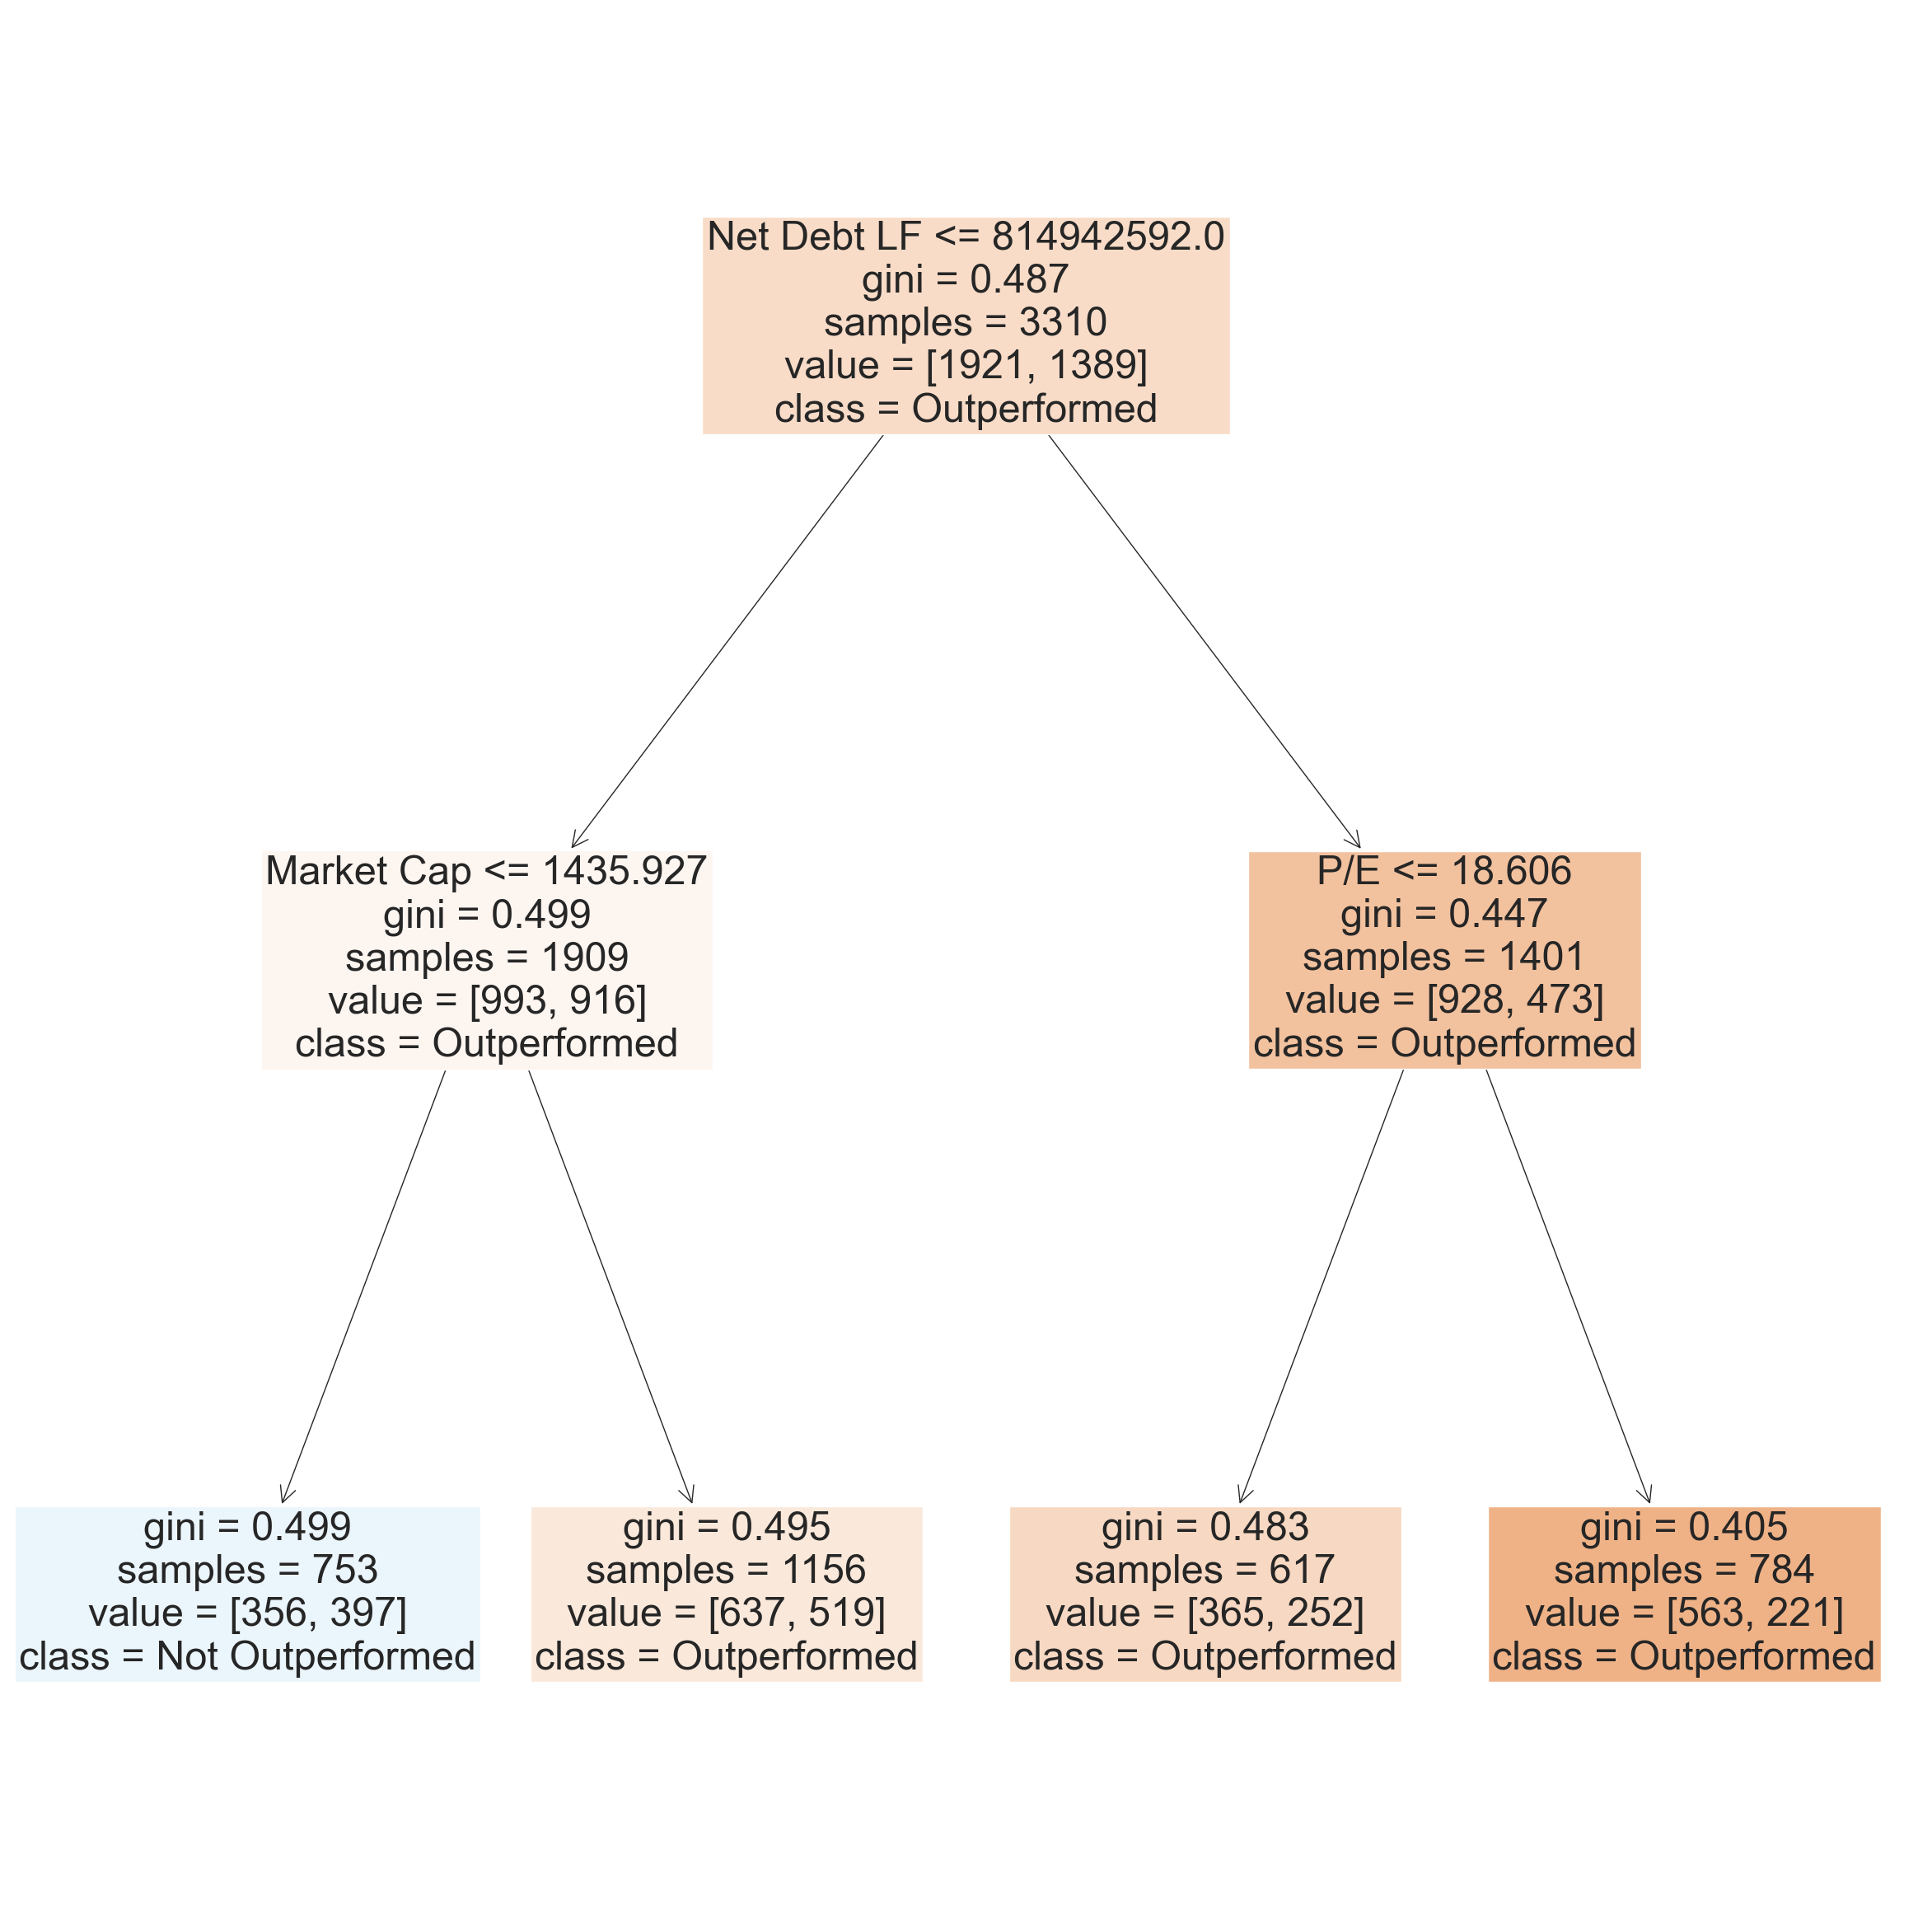

In [80]:
former_df["Compared Performance"] = np.where(
    (former_df['Market Cap_perf'] > former_df['Market Cap_perf'].mean()), "Outperformed", "Not Outperformed")
y_train = former_df["Compared Performance"]
X_train = former_df.drop(
    columns=["Compared Performance", "Market Cap_perf", "Name", "GICS Sector"])

CrP["Compared Performance"] = np.where(
    (CrP['Market Cap_perf'] > CrP['Market Cap_perf'].mean()), "Outperformed", "Not Outperformed")
y_test = CrP["Compared Performance"]
X_test = CrP.drop(
    columns=["Compared Performance", "Market Cap_perf", "Name", "GICS Sector"])

fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x="Compared Performance", data=all_df)
plt.title("Target distribution")
plt.show()

print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

print("Using the data of concluded periods as training data and the current, ongoing period data, as test data")
dt = DecisionTreeClassifier(max_depth=2)

dt.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(dt, feature_names=X_train.columns, class_names=[
    "Outperformed", "Not Outperformed"], filled=True,  proportion=False, fontsize=35)

evaluate(dt, X_train, X_test, y_train, y_test)


### 3.2 Random Forest with Hyperparametertuning

In [35]:
n_estimators = [5, 10, 25, 50, 100]
max_features = ['auto', 'sqrt']
max_depth = np.arange(2, 22, 2)
min_samples_split = [5, 10, 25, 50, 100, 200]
min_samples_leaf = [5, 10, 25, 50, 100, 200]
bootstrap = [True, False]

params_arr = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}


In [36]:
# def viduslize_best(clf, params):


SyntaxError: incomplete input (2628051651.py, line 1)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree

# current is test
rf = RandomForestClassifier()

rf_Grid = GridSearchCV(estimator=rf, param_grid=params_arr,
                       cv=4, verbose=3, n_jobs=-1)
rf_Grid.fit(X_train.values, y_train.values)

params = {'bootstrap': [rf_Grid.best_params_["bootstrap"]],
          'max_depth': [rf_Grid.best_params_['max_depth']],
          'max_features': [rf_Grid.best_params_['max_features']],
          'min_samples_leaf': [rf_Grid.best_params_['min_samples_leaf']],
          'min_samples_split': [rf_Grid.best_params_['min_samples_split']],
          'n_estimators': [rf_Grid.best_params_['n_estimators']]}

print(params)

current_test_Grid = GridSearchCV(estimator=rf, param_grid=params,
                                 cv=4, verbose=3, n_jobs=-1)
current_test_Grid.fit(X_train.values, y_train.values)

evaluate(current_test_Grid, X_train.values,
         X_test.values, y_train.values, y_test.values)

CrP.drop(["Compared Performance"], axis=1, inplace=True)


Fitting 4 folds for each of 7200 candidates, totalling 28800 fits
{'bootstrap': [True], 'max_depth': [2], 'max_features': ['auto'], 'min_samples_leaf': [100], 'min_samples_split': [100], 'n_estimators': [10]}
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Train Accuracy : 0.5894259818731118
Train Confusion Matrix:
[[1857   64]
 [1295   94]]
Test Accuracy : 0.5074509803921569
Test Confusion Matrix:
[[629  13]
 [615  18]]


c:\Users\lucar\anaconda3\envs\ds\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

c:\Users\lucar\anaconda3\envs\ds\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



In [38]:
params = {'bootstrap': [rf_Grid.best_params_["bootstrap"]],
          'max_depth': [rf_Grid.best_params_['max_depth']],
          'max_features': [rf_Grid.best_params_['max_features']],
          'min_samples_leaf': [rf_Grid.best_params_['min_samples_leaf']],
          'min_samples_split': [rf_Grid.best_params_['min_samples_split']],
          'n_estimators': [rf_Grid.best_params_['n_estimators']]}


In [39]:
clf = RandomForestClassifier(bootstrap=params["bootstrap"][0], max_depth=params["max_depth"][0], max_features=params["max_features"][0],
                             min_samples_leaf=params["min_samples_leaf"][0], min_samples_split=params["min_samples_split"][0], n_estimators=params["n_estimators"][0])
clf.fit(X_train.values, y_train.values)


c:\Users\lucar\anaconda3\envs\ds\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



RandomForestClassifier(max_depth=2, max_features='auto', min_samples_leaf=100,
                       min_samples_split=100, n_estimators=10)

In [40]:
import os
from sklearn.tree import export_graphviz
import six
import pydot
from sklearn import tree

dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in clf.estimators_:
    export_graphviz(tree_in_forest, out_file='tree.dot',
                    feature_names=X_train.columns,
                    filled=True)
    (graph,) = pydot.graph_from_dot_file('tree.dot')
    name = 'tree' + str(i_tree)
    graph.write_png(name + '.png')
    os.system('dot -Tpng tree.dot -o tree.png')
    i_tree += 1


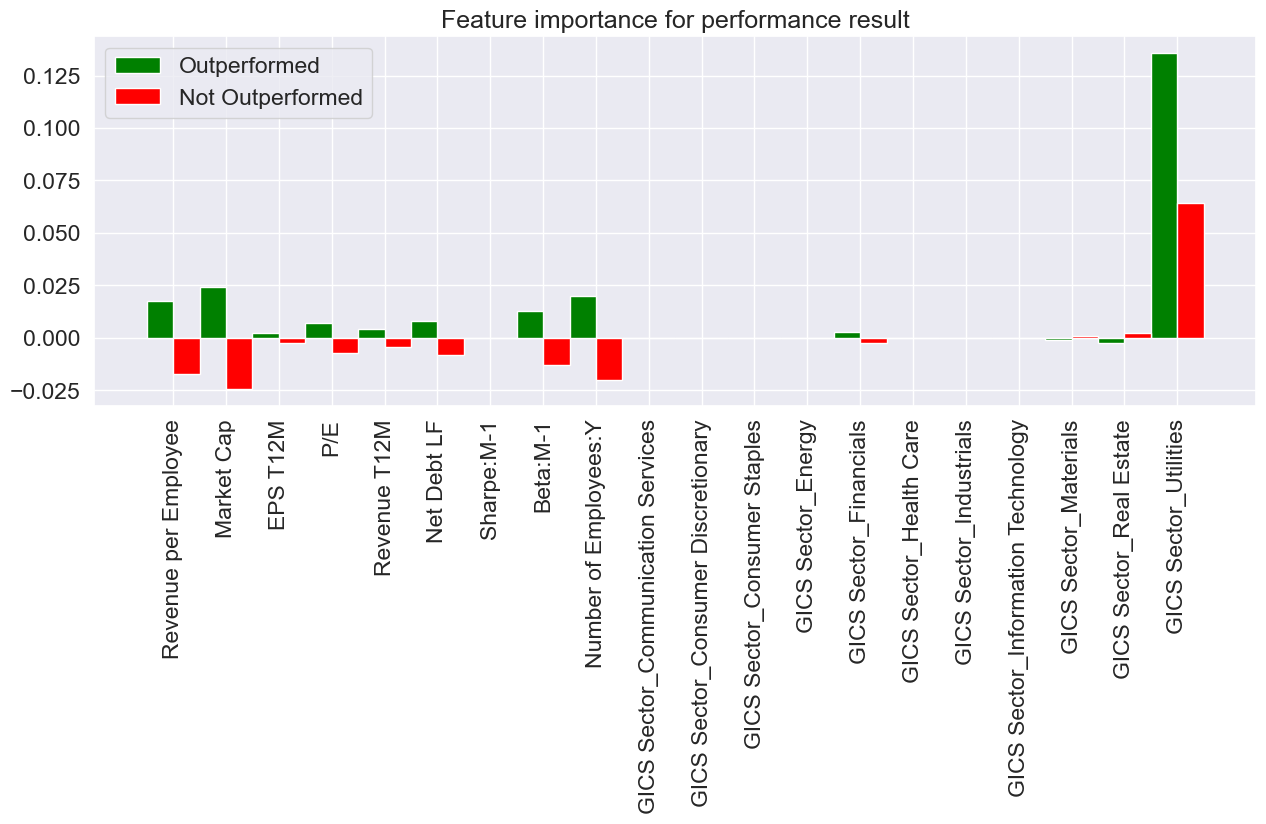

In [41]:
from treeinterpreter import treeinterpreter as ti
prediction, bias, contributions = ti.predict(clf, X_test.values)
N = 20

outperformed = []
not_outperformed = []

for j in range(2):
    list_ = [outperformed, not_outperformed]
    for i in range(19):
        val = contributions[0, i, j]
        list_[j].append(val)

outperformed.append(prediction[0, 0]/5)
not_outperformed.append(prediction[0, 1]/5)

fig, ax = plt.subplots()
ind = np.arange(N)

width = 0.5

p1 = ax.bar(ind, outperformed, width, color='green', bottom=0)
p2 = ax.bar(ind+width, not_outperformed, width, color='red', bottom=0)

ax.set_title(
    'Feature importance for performance result')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(X_train.columns, rotation=90)
ax.legend((p1[0], p2[0]), ('Outperformed',
          'Not Outperformed'), loc="upper left")
ax.autoscale_view()

fig.set_figwidth(15)
plt.show()


In [42]:
# all_df
y = all_df["Compared Performance"]
X = all_df.drop(
    columns=["Compared Performance", "Market Cap_perf", "Name", "GICS Sector"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

rf = RandomForestClassifier()

rf_Grid = GridSearchCV(estimator=rf, param_grid=params_arr,
                       cv=4, verbose=3, n_jobs=-1)
rf_Grid.fit(X_train.values, y_train.values)

params = {'bootstrap': [rf_Grid.best_params_["bootstrap"]],
          'max_depth': [rf_Grid.best_params_['max_depth']],
          'max_features': [rf_Grid.best_params_['max_features']],
          'min_samples_leaf': [rf_Grid.best_params_['min_samples_leaf']],
          'min_samples_split': [rf_Grid.best_params_['min_samples_split']],
          'n_estimators': [rf_Grid.best_params_['n_estimators']]}

print(params)

all_Grid = GridSearchCV(estimator=rf, param_grid=params,
                        cv=4, verbose=3, n_jobs=-1)
all_Grid.fit(X_train.values, y_train.values)

evaluate(all_Grid, X_train.values, X_test.values,
         y_train.values, y_test.values)


Fitting 4 folds for each of 7200 candidates, totalling 28800 fits


c:\Users\lucar\anaconda3\envs\ds\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



{'bootstrap': [False], 'max_depth': [20], 'max_features': ['auto'], 'min_samples_leaf': [5], 'min_samples_split': [50], 'n_estimators': [50]}
Fitting 4 folds for each of 1 candidates, totalling 4 fits


c:\Users\lucar\anaconda3\envs\ds\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



Train Accuracy : 0.8669413475521086
Train Confusion Matrix:
[[2160  158]
 [ 391 1417]]
Test Accuracy : 0.6361655773420479
Test Confusion Matrix:
[[204  61]
 [106  88]]


In [43]:
all_Grid


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [20],
                         'max_features': ['auto'], 'min_samples_leaf': [5],
                         'min_samples_split': [50], 'n_estimators': [50]},
             verbose=3)

In [44]:
# only former_df
y = former_df["Compared Performance"]
X = former_df.drop(
    columns=["Compared Performance", "Market Cap_perf", "Name", "GICS Sector"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

rf = RandomForestClassifier()

rf_Grid = GridSearchCV(estimator=rf, param_grid=params_arr,
                       cv=4, verbose=3, n_jobs=-1)
rf_Grid.fit(X_train.values, y_train.values)

params = {'bootstrap': [rf_Grid.best_params_["bootstrap"]],
          'max_depth': [rf_Grid.best_params_['max_depth']],
          'max_features': [rf_Grid.best_params_['max_features']],
          'min_samples_leaf': [rf_Grid.best_params_['min_samples_leaf']],
          'min_samples_split': [rf_Grid.best_params_['min_samples_split']],
          'n_estimators': [rf_Grid.best_params_['n_estimators']]}

print(params)

former_Grid = GridSearchCV(estimator=rf, param_grid=params,
                           cv=4, verbose=3, n_jobs=-1)
former_Grid.fit(X_train.values, y_train.values)

evaluate(former_Grid, X_train.values, X_test.values,
         y_train.values, y_test.values)


Fitting 4 folds for each of 7200 candidates, totalling 28800 fits


c:\Users\lucar\anaconda3\envs\ds\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



{'bootstrap': [False], 'max_depth': [10], 'max_features': ['auto'], 'min_samples_leaf': [5], 'min_samples_split': [10], 'n_estimators': [50]}
Fitting 4 folds for each of 1 candidates, totalling 4 fits


c:\Users\lucar\anaconda3\envs\ds\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



Train Accuracy : 0.8482712319570326
Train Confusion Matrix:
[[1667   59]
 [ 393  860]]
Test Accuracy : 0.6404833836858006
Test Confusion Matrix:
[[159  36]
 [ 83  53]]


In [45]:
former_Grid


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [10],
                         'max_features': ['auto'], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [50]},
             verbose=3)

### Observations and Insights
#### Observations
-   qdwed
-   qdwqd

#### Insights
The best results stemmed from a classifier using the data from all periods, despite it including the current/not-concluded period. We will use it for our portfolio creation.

## 3.3 Predictor implementation
COMPARED TO INVESTING INTO THE SP1500 ONLY

Using the findings from above we can determine the companies predicted to outperform

In [46]:
import statistics

# we add all companies that have been identified as "Outperformed" and assign equal weights
all_classifier_performance = []
former_classifier_performance = []
current_test_classifier_performance = []

# calculating the portfolio performances
for df in all_dfs:
    all_outperformer_perf = []
    former_outperformer_perf = []
    current_test_outperformer_perf = []

    compare_df = df.drop(["Market Cap_perf", "Name", "GICS Sector"], axis=1)
    for i in range(df.shape[0]):
        if all_Grid.predict([compare_df.iloc[i].values]) == "Outperformed":
            all_outperformer_perf.append(df.iloc[i, 0])
        if former_Grid.predict([compare_df.iloc[i].values]) == "Outperformed":
            former_outperformer_perf.append(df.iloc[i, 0])
        if current_test_Grid.predict([compare_df.iloc[i].values]) == "Outperformed":
            current_test_outperformer_perf.append(df.iloc[i, 0])

    all_classifier_performance.append(1+statistics.mean(all_outperformer_perf))
    former_classifier_performance.append(
        1+statistics.mean(former_outperformer_perf))
    current_test_classifier_performance.append(
        1+statistics.mean(current_test_outperformer_perf))


In [47]:
# importing comparative indices/assets, gold is still saved
sp1500 = yf_import(
    "^SP1500", periods.iloc[0]['Start'], periods.iloc[-1]["Last"])
nasdaq = yf_import("^IXIC", periods.iloc[0]['Start'], periods.iloc[-1]["Last"])
WTI = web.DataReader(
    'WTISPLC', "fred", periods.iloc[0]['Start'], periods.iloc[-1]["Last"])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [48]:
performance = periods
gold_performance = []
sp1500_performance = []
nasdaq_performance = []
WTI_performance = []

# creating a dataframe to compare perfomances of the portfolios with common indices and "crisis" ressources

for index, row in periods.iterrows():
    gold_performance.append((1+((gold.loc[row["Last"]].values)-(
        gold.loc[row["Start"]].values))/(gold.loc[row["Start"]].values)).item())

    sp1500_performance.append((1+((sp1500.loc[row["Last"]].values)-(
        sp1500.loc[row["Start"]].values))/(sp1500.loc[row["Start"]].values)).item())

    nasdaq_performance.append((1+((nasdaq.loc[row["Last"]].values)-(
        nasdaq.loc[row["Start"]].values))/(nasdaq.loc[row["Start"]].values)).item())

    WTI_performance.append((1+((WTI.loc[row["Last"]].values)-(
        WTI.loc[row["Start"]].values))/(WTI.loc[row["Start"]].values)).item())


In [49]:
performance["Gold"] = gold_performance
performance["Nasdaq"] = nasdaq_performance
performance["Spot Crude Oil Price WTI"] = WTI_performance
performance["S&P 1500"] = sp1500_performance
performance["all_Grid"] = all_classifier_performance
performance["former_Grid"] = former_classifier_performance
performance["current_test_Grid"] = current_test_classifier_performance
performance


Name       Start        Last  Duration      Gold    Nasdaq  \
0  Period 1  2004-04-01  2006-08-01        27  1.626804  1.047715   
1  Period 2  2016-09-01  2017-08-01        10  1.002506  1.201220   
2  Period 3  2017-09-01  2018-07-01         9  0.956180  1.206716   
3  Period 4  2022-01-01  2023-03-01        13  1.020625  0.788331   

   Spot Crude Oil Price WTI  S&P 1500  all_Grid  former_Grid  \
0                  1.991006  1.148445  1.587487     1.724638   
1                  1.063302  1.135936  1.301958     1.392897   
2                  1.424729  1.124224  1.320112     1.434718   
3                  0.880558  0.874502  1.217708     0.928723   

   current_test_Grid  
0           1.478992  
1           1.212275  
2           1.338581  
3           0.923262